In [1]:
pretty = True
highres = True

%matplotlib inline
if highres:
    %config InlineBackend.figure_format = 'retina'
else:
    %config InlineBackend.figure_format = 'png'

#rcParams["figure.dpi"]=300

import sys
from pathlib import Path

pypsapath = "C:/dev/py/PyPSA/"

if sys.path[0] != pypsapath:
    sys.path.insert(0,pypsapath)

if Path("../..") not in [Path(p) for p in sys.path]:
    sys.path.insert(0,"../..")

%load_ext autoreload
%autoreload 2

In [2]:
import src.globals
from src.scigridnetwork import SciGRID_network
from src.armafitloader import ARMAfit_loader
import src.plothelper

Git root path found at: C:\dev\grid-analysis
Using data path:        C:\dev\grid-analysis\data


In [103]:
import pypsa
import numpy as np
import pandas as pd
import os
import itertools
import scipy.stats

import matplotlib.pyplot as plt
import matplotlib.ticker
import matplotlib.dates
import matplotlib.font_manager
from matplotlib import rcParams
import cartopy

rcParams["font.family"] = "sans-serif"


from IPython.display import Markdown, display
printm = lambda s: display(Markdown(s))

In [4]:
sgn = SciGRID_network()

Importing PyPSA from older version of PyPSA than current version 0.13.2.
Please read the release notes at https://pypsa.org/doc/release_notes.html
carefully to prepare your network for import.



0.13.2 ['C:/dev/py/PyPSA\\pypsa']


In [5]:
month_index = 0
month_name = ARMAfit_loader.monthnames[month_index]

solar_res_cov = np.load(src.globals.data_path / "processed" / "covariance" / month_name / "solar_resdaylightcov.npy")
wind_res_cov = np.load(src.globals.data_path / "processed" / "covariance" / month_name / "wind_rescov.npy")
solar_gen_cov = np.load(src.globals.data_path / "processed" / "covariance" / month_name / "solar_gendaylightcov.npy")
wind_gen_cov = np.load(src.globals.data_path / "processed" / "covariance" / month_name / "wind_gencov.npy")
solar_diff_cov = np.load(src.globals.data_path / "processed" / "covariance" / month_name / "solar_diffdaylightcov.npy")
wind_diff_cov = np.load(src.globals.data_path / "processed" / "covariance" / month_name / "wind_diffcov.npy")
solar_diff_cov_norm = np.load(src.globals.data_path / "processed" / "covariance" / month_name / "solar_diffdaylightcovnorm.npy")
wind_diff_cov_norm = np.load(src.globals.data_path / "processed" / "covariance" / month_name / "wind_diffcovnorm.npy")

In [6]:
bus_res_cov_day = wind_res_cov + solar_res_cov
bus_res_cov_night = wind_res_cov
bus_gen_cov_day = wind_gen_cov + solar_gen_cov
bus_gen_cov_night = wind_gen_cov
bus_diff_cov_day = wind_diff_cov + solar_diff_cov
bus_diff_cov_night = wind_diff_cov
bus_diff_cov_day_norm = wind_diff_cov_norm + solar_diff_cov_norm
bus_diff_cov_night_norm = wind_diff_cov_norm

bus_res_cov_solar = solar_res_cov
bus_gen_cov_solar = solar_gen_cov
bus_diff_cov_solar = solar_diff_cov

In [7]:
line_res_cov_day = sgn.F @ bus_res_cov_day @ sgn.F.T
line_res_cov_night = sgn.F @ bus_res_cov_night @ sgn.F.T
line_gen_cov_day = sgn.F @ bus_gen_cov_day @ sgn.F.T
line_gen_cov_night = sgn.F @ bus_gen_cov_night @ sgn.F.T
line_diff_cov_day = sgn.F @ bus_diff_cov_day @ sgn.F.T
line_diff_cov_night = sgn.F @ bus_diff_cov_night @ sgn.F.T

line_res_cov_solar = sgn.F @ bus_res_cov_solar @ sgn.F.T
line_gen_cov_solar = sgn.F @ bus_gen_cov_solar @ sgn.F.T
line_diff_cov_solar = sgn.F @ bus_diff_cov_solar @ sgn.F.T

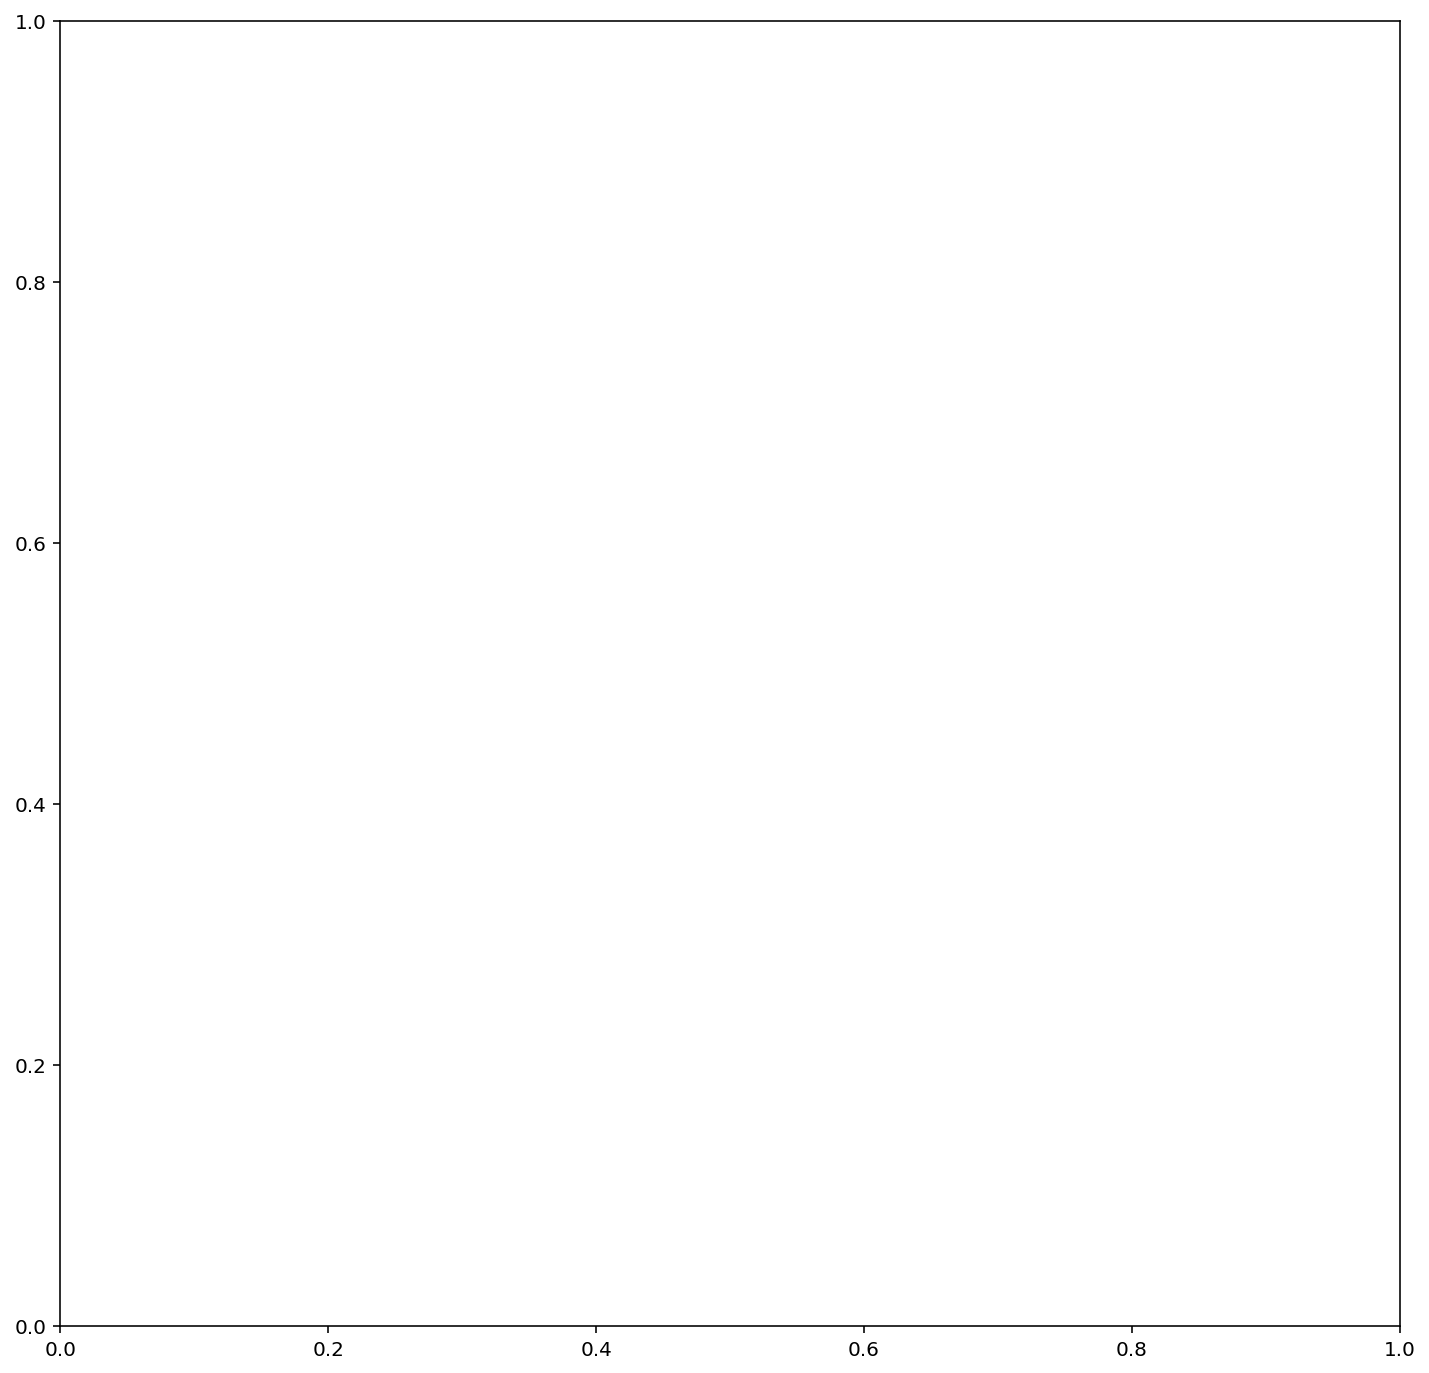

In [8]:
fig, ax = plt.subplots(figsize=(12,12))
# ax.imshow(line_gen_cov_day, cmap="PiYG")

In [9]:
des = lambda x: pd.Series(x).describe()

des(np.sqrt(np.diagonal(line_diff_cov_day)))

count    695.000000
mean      53.239495
std       58.748402
min        0.059617
25%       12.037059
50%       32.503593
75%       78.099228
max      496.847878
dtype: float64

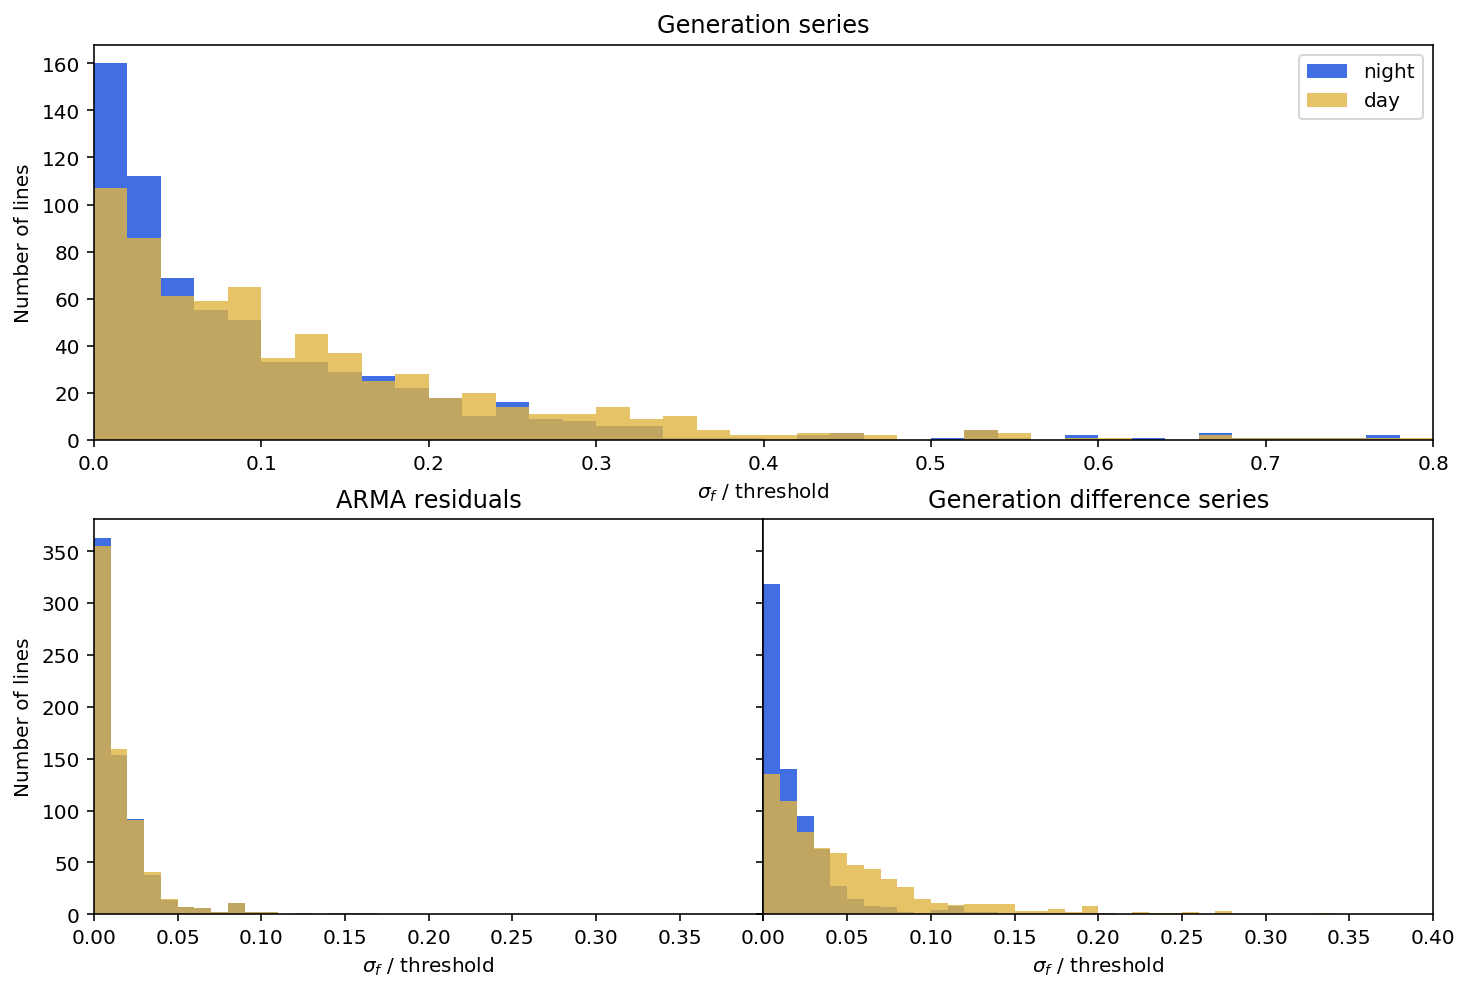

In [60]:
fig = plt.figure(figsize=(12,8))

gs = fig.add_gridspec(2,2)
gs.update(wspace=0.00)
ax0 = fig.add_subplot(gs[0, :])
ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[1, 1], sharex=ax1, sharey=ax1)


binscoarse = np.arange(0.0,1.0,0.02)
binsfine = np.arange(0.0,1.0,0.01)


ax0.hist(np.sqrt(np.diagonal(line_gen_cov_night)) / sgn.line_threshold, bins=binscoarse, color=src.globals.wind_color, label="night")
ax0.hist(np.sqrt(np.diagonal(line_gen_cov_day)) / sgn.line_threshold, bins=binscoarse, color=src.globals.solar_color, label="day", alpha=.8)
ax0.set_title("Generation series")
ax0.set_xlabel("$σ_{f}$ / threshold")
ax0.set_ylabel("Number of lines")
ax0.legend()
ax0.set_xlim(0.0, .8)

ax1.hist(np.sqrt(np.diagonal(line_res_cov_night)) / sgn.line_threshold, bins=binsfine, color=src.globals.wind_color, label="night")
ax1.hist(np.sqrt(np.diagonal(line_res_cov_day)) / sgn.line_threshold, bins=binsfine, color=src.globals.solar_color, label="day", alpha=.8)
ax1.set_title("ARMA residuals")
ax1.set_xlabel("$σ_{f}$ / threshold")
ax1.set_ylabel("Number of lines")
#ax1.legend()

ax2.hist(np.sqrt(np.diagonal(line_diff_cov_night)) / sgn.line_threshold, bins=binsfine, color=src.globals.wind_color, label="night")
ax2.hist(np.sqrt(np.diagonal(line_diff_cov_day)) / sgn.line_threshold, bins=binsfine, color=src.globals.solar_color, label="day", alpha=.8)
ax2.set_title("Generation difference series")
ax2.set_xlabel("$σ_{f}$ / threshold")
#ax2.set_ylabel("Number of lines")
#ax2.legend()


ax1.set_xlim(0.0, 0.4)

_=plt.setp(ax2.get_yticklabels(), visible=False)
_=plt.setp(ax1.get_xticklabels()[-1], visible=False)
# ax[0].set_title("Histogram of line stdevs")



#ax[2].set_title("Histogram of line stdevs (direct)")



#ax[3].set_title("Histogram of line stdevs (difference)")


# ax[0].set_xlim(0.0,.4)

plt.savefig("line_cov_direct_arma_diff.pdf",bbox_inches="tight")

In [61]:
describeshort = lambda series: printm("|range | mean | \n |---|---| \n | $[{0:.6f},{1:.6f}]$ | ${2:.4f}$ |".format(np.min(series), np.max(series), np.mean(series)))

printm("# Proxy")
printm("During daytime:")
describeshort(np.sqrt(np.diagonal(line_res_cov_day)) / sgn.line_threshold)
printm("_Alt 1_: Night residues, 25% differences")
describeshort((np.sqrt(np.diagonal(line_res_cov_night) + .25*np.diagonal(line_diff_cov_solar))) / sgn.line_threshold)
printm("_Alt 2_: Night residues, 10% direct")
describeshort((np.sqrt(np.diagonal(line_res_cov_night) + .1*np.diagonal(line_gen_cov_solar))) / sgn.line_threshold)

printm("During nighttime:")
describeshort(np.sqrt(np.diagonal(line_res_cov_night)) / sgn.line_threshold)

printm("# Direct")
printm("During daytime:")
describeshort(np.sqrt(np.diagonal(line_gen_cov_day)) / sgn.line_threshold)

printm("During nighttime:")
describeshort(np.sqrt(np.diagonal(line_gen_cov_night)) / sgn.line_threshold)

printm("# Differences")
printm("During daytime:")
describeshort(np.sqrt(np.diagonal(line_diff_cov_day)) / sgn.line_threshold)

printm("During nighttime:")
describeshort(np.sqrt(np.diagonal(line_diff_cov_night)) / sgn.line_threshold)

# Proxy

During daytime:

|range | mean | 
 |---|---| 
 | $[0.000014,0.161384]$ | $0.0157$ |

_Alt 1_: Night residues, 25% differences

|range | mean | 
 |---|---| 
 | $[0.000032,0.185563]$ | $0.0278$ |

_Alt 2_: Night residues, 10% direct

|range | mean | 
 |---|---| 
 | $[0.000032,0.183614]$ | $0.0276$ |

During nighttime:

|range | mean | 
 |---|---| 
 | $[0.000014,0.160666]$ | $0.0154$ |

# Direct

During daytime:

|range | mean | 
 |---|---| 
 | $[0.000132,1.440786]$ | $0.1363$ |

During nighttime:

|range | mean | 
 |---|---| 
 | $[0.000096,1.413101]$ | $0.1103$ |

# Differences

During daytime:

|range | mean | 
 |---|---| 
 | $[0.000060,0.338016]$ | $0.0485$ |

During nighttime:

|range | mean | 
 |---|---| 
 | $[0.000017,0.205282]$ | $0.0198$ |

In [62]:
armafits = ARMAfit_loader(sgn)

In [63]:
# sgn_fullyear = SciGRID_network()
# sgn_fullyear.network.generators_t.p_max_pu
# sgn2.network.generators_t.p_max_pu

In [64]:
printm("## `sgn`:")
printm("Average national solar generation: {0:.0f} MW".format(armafits.solar_generationmonth.sum(axis=0).mean()))
printm("Average national wind generation: {0:.0f} MW".format(armafits.wind_generationmonth.sum(axis=0).mean()))

## `sgn`:

Average national solar generation: 3170 MW

Average national wind generation: 10805 MW

In [65]:
# sgn2= SciGRID_network(Path(pypsapath) / "examples" / "scigrid-de" / "scigrid-with-load-gen-trafos")
# armafits2 = ARMAfit_loader(sgn2)

In [66]:
# printm("## `sgn2`:")
# printm("Average national solar generation: {0:.0f} MW".format(armafits2.solar_generationmonth.sum(axis=0).mean()))
# printm("Average national wind generation: {0:.0f} MW".format(armafits2.wind_generationmonth.sum(axis=0).mean()))

In [67]:
# sgn_jan1 = sgn.solar_generation[:,:24]
# sgn2_jan1 = sgn2.solar_generation[:,:24]
# coincide = np.all(sgn_jan1 == sgn2_jan1)

# printm("`sgn` and `sgn2` **{}** coincide on January 1, 2011.".format("DO" if coincide else "DO NOT"))

# 🌼

In [68]:
sgn.run_lopf_jan1()

Performing linear OPF for one day, 4 snapshots at a time:


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:40<00:00,  6.65s/it]


In [69]:
# sgn2.run_lopf_jan1()

In [70]:
# # No difference:
# sgn3.network.storage_units = sgn.network.storage_units
# sgn3.network.storage_units_t = sgn.network.storage_units_t

# # No difference:
# sgn3.network.transformers = sgn.network.transformers
# sgn3.network.transformers_t = sgn.network.transformers_t
# sgn3.network.transformer_types = sgn.network.transformer_types
# sgn3.network.transformer_types_t = sgn.network.transformer_types_t

# # DOES make a difference:
# sgn3.network.lines = sgn.network.lines
# sgn3.network.lines_t = sgn.network.lines_t
# sgn3.network.line_types = sgn.network.line_types
# sgn3.network.line_types_t = sgn.network.line_types_t

# # 
# sgn3.network.links = sgn.network.links
# sgn3.network.links_t = sgn.network.links_t

# # sgn3.run_lopf_jan1()

In [71]:
# sgn3_line_flow_jan1 = sgn3.line_flow_linear.values
# sgn2_line_flow_jan1 = sgn2.line_flow_linear.values
# coincide_line_flow = np.all(sgn3_line_flow_jan1 == sgn2_line_flow_jan1)

# printm("`sgn3` and `sgn2` line flows **{}** coincide on January 1, 2011.".format("DO" if coincide_line_flow else "DO NOT"))

In [72]:
# sgn3_line_flow_jan1 = sgn3.line_flow_linear.values
# sgn_line_flow_jan1 = sgn.line_flow_linear.values
# coincide_line_flow = np.all(sgn3_line_flow_jan1 == sgn_line_flow_jan1)

# printm("`sgn3` and `sgn` line flows **{}** coincide on January 1, 2011.".format("DO" if coincide_line_flow else "DO NOT"))

In [73]:
# sgn2_line_flow_jan1 = sgn2.line_flow_linear.values
# sgn_line_flow_jan1 = sgn.line_flow_linear.values
# coincide_line_flow = np.all(sgn2_line_flow_jan1 == sgn_line_flow_jan1)

# printm("`sgn2` and `sgn` line flows **{}** coincide on January 1, 2011.".format("DO" if coincide_line_flow else "DO NOT"))

In [74]:
# sgn3.network.loads_t.p

In [75]:
# 100*(sgn2.line_flow_total - sgn.line_flow_total) / sgn2.line_flow_total

# 🌷

In [76]:
fav_sgn = sgn

In [77]:
elevenAM = fav_sgn.network.generators_t.p.index[11]

print(f"Total load: {fav_sgn.network.loads_t.p_set.loc[elevenAM,:].sum()} MW")
print(f"Total generation: {fav_sgn.network.generators_t.p.loc[elevenAM,:].sum()} MW")
print(f"Generation overshoot: {fav_sgn.injection_total.loc[elevenAM,:].sum()} MW")

Total load: 52524.64000000083 MW
Total generation: 52950.84000000398 MW
Generation overshoot: 426.20000000314803 MW


In [78]:
#pd.Series(sgn2.line_saturation_total.values[11])
#sgn2.network.lines_t.p1.values[11]# / sgn2.network.lines.s_nom
#sgn2.line_flow_total

In [93]:
line_ratings = fav_sgn.get_line_ratings(bus_diff_cov_day)
f=line_ratings.f
lr20 = line_ratings.sort_values("P>1", ascending=False).head(20)

riskiest20 = set(lr20.index)

lr20

l         f         σ       P>1      rate
651       [809]  0.700000  0.229494  0.095568  0.854420
652       [810] -0.681245  0.237297  0.089591  0.902194
411       [516] -0.700000  0.203939  0.070642  1.081965
54         [58]  0.614813  0.250550  0.062102  1.181745
298       [361] -0.700000  0.165036  0.034548  1.652178
473       [584]  0.370513  0.338016  0.031306  1.734079
213       [249] -0.700000  0.151372  0.023747  1.963915
25         [27] -0.700000  0.147734  0.021144  2.061833
645       [803] -0.700000  0.146402  0.020223  2.099520
74         [80] -0.429590  0.276626  0.019603  2.125974
472       [583] -0.426195  0.272495  0.017613  2.217075
251       [302] -0.698663  0.140522  0.016000  2.299266
44         [48] -0.699312  0.135294  0.013125  2.469705
26         [28] -0.700000  0.128545  0.009803  2.723336
17         [19] -0.700000  0.126188  0.008717  2.826043
163       [183]  0.700000  0.120655  0.006452  3.091180
564       [715] -0.700000  0.118997  0.005850  3.177893
27         [29]  0.689670  0.121826  0.005428  3.244406
414       [519]  0.474421  0.198590  0.004066  3.502105
315  [389, 390]  0.699914  0.106723  0.002463  3.953151

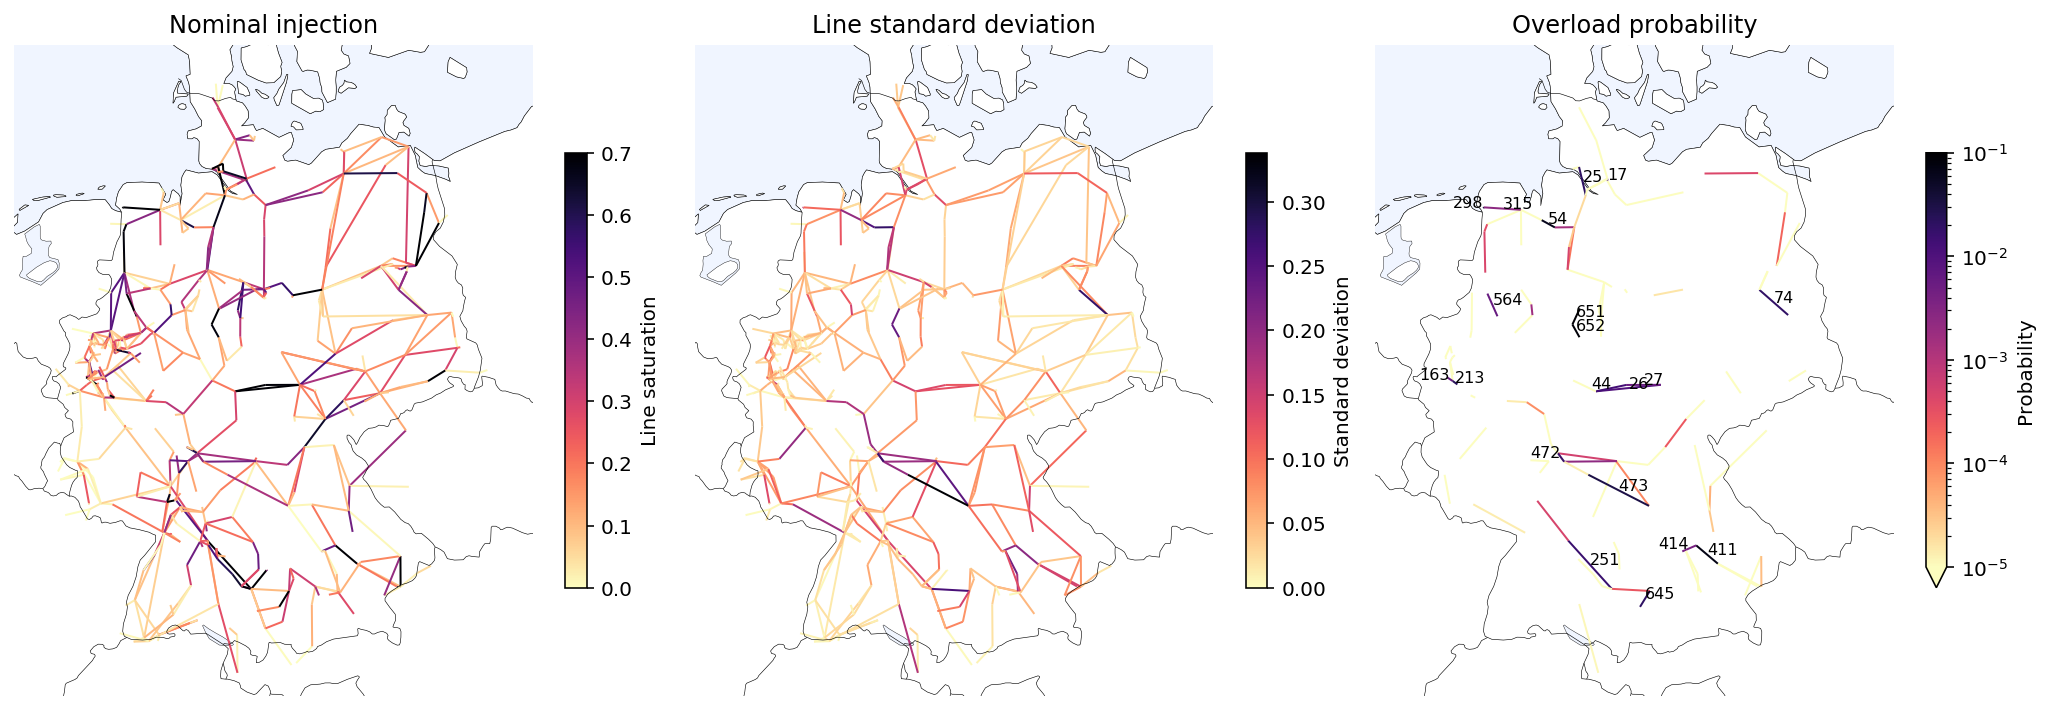

In [117]:
fig = plt.figure(figsize=(18,8))
import cartopy.crs as ccrs 
ax = fig.subplots(1,3,subplot_kw={"projection":ccrs.TransverseMercator(central_longitude=10.0, central_latitude=50.0)}).flatten()

geomap = "50m"


# --

line_colors, line_widths = fav_sgn.line_array_to_plot(np.abs(line_ratings["f"]))
# bus_sizes, bus_colors = fav_sgn.bus_array_to_plot(fav_sgn.injection_total.loc[elevenAM])
bus_sizes, bus_colors = fav_sgn.bus_array_to_plot()

pathcol, linecol = fav_sgn.network.plot(geomap=geomap, bus_sizes=bus_sizes, bus_colors=bus_colors, line_colors=line_colors, line_widths=line_widths, line_cmap="magma_r", ax=ax[0])
cbar = fig.colorbar(linecol, ax=ax[0], shrink=.5)
cbar.set_label("Line saturation")
ax[0].set_title("Nominal injection")


# --

line_colors, line_widths = fav_sgn.line_array_to_plot(np.abs(line_ratings["σ"]))

pathcol, linecol = fav_sgn.network.plot(geomap=geomap, bus_sizes=bus_sizes, bus_colors=bus_colors, line_colors=line_colors, line_widths=line_widths, line_cmap="magma_r", ax=ax[1])
cbar = fig.colorbar(linecol, ax=ax[1], shrink=.5)
cbar.set_label("Standard deviation")
ax[1].set_title("Line standard deviation")


# --

line_colors, line_widths = fav_sgn.line_array_to_plot(np.abs(line_ratings["P>1"]))

pathcol, linecol = fav_sgn.network.plot(geomap=geomap, bus_sizes=bus_sizes, bus_colors=bus_colors, line_colors=line_colors, line_widths=line_widths, line_cmap="magma_r", ax=ax[2])
linecol.norm = matplotlib.colors.LogNorm()
linecol.set_clim(1e-5, 1e-1)
cbar = fig.colorbar(linecol, ax=ax[2], shrink=.5, extend="min")
cbar.set_label("Probability")
ax[2].set_title("Overload probability")

prefer_left = {298, 163, 44, 472, 414}

for l in riskiest20:
    xy = fav_sgn.line_centres_lon_lat[l]
    pxy = ax[2].projection.transform_point(*xy,cartopy.crs.PlateCarree())
    ax[2].text(*pxy, str(l), fontsize=8, horizontalalignment=('right' if l in prefer_left else 'left'))


# --

for axi in ax:
    src.plothelper.add_water_to_axis(axi, geomap)

plt.subplots_adjust(wspace=.05)

plt.savefig("nomflow_stdev_trueoverloadprob_labeled.pdf", bbox_inches="tight")

In [108]:


# cartopy._crs.CRS.transform_point()


(-1005894.535971642, -5428885.151463385)

NameError: name 'line_ratings_reindexed' is not defined

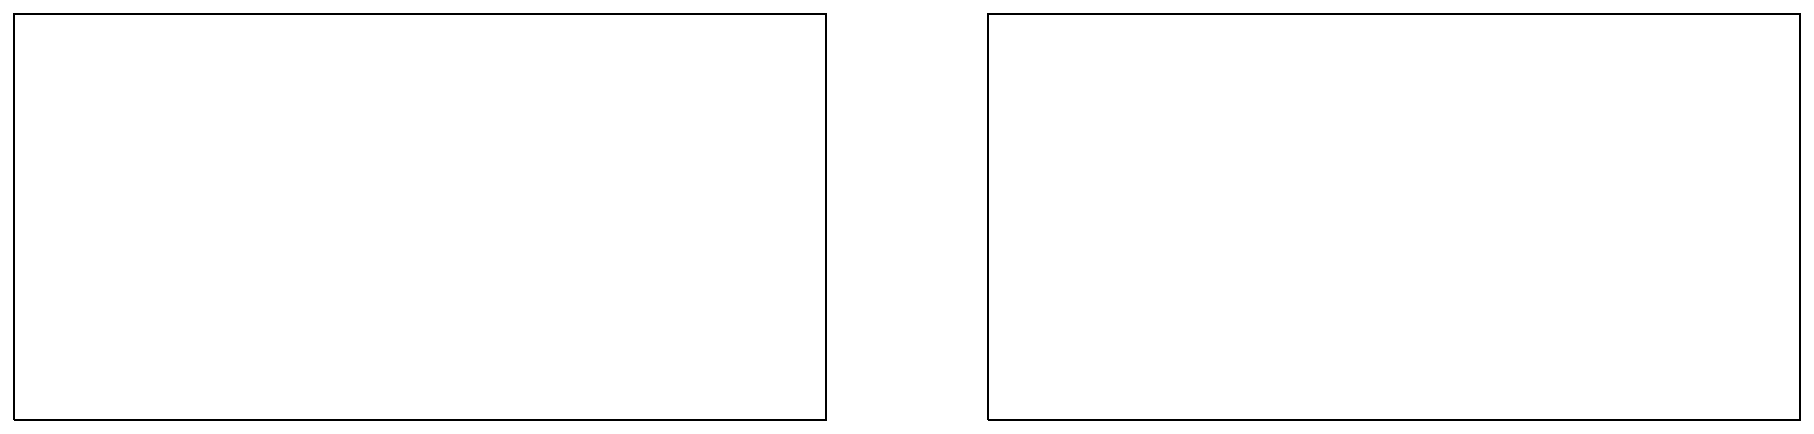

In [183]:
fig = plt.figure(figsize=(16,8))
import cartopy.crs as ccrs
import cartopy.feature
ax = fig.subplots(1,2,subplot_kw={"projection":ccrs.TransverseMercator(central_longitude=10.0, central_latitude=50.0)}).flatten()

bus_sizes = [0]*len(fav_sgn.network.buses)
bus_colors = ['g']*len(fav_sgn.network.buses)

for i, bus_name in enumerate(fav_sgn.network.buses.index):
    if bus_name in fav_sgn.new_nodes:
        powerinj = (fav_sgn.injection_total.loc[elevenAM,:])[fav_sgn.node_index(bus_name)]
        bus_sizes[i] = np.abs(powerinj) / 10
        bus_colors[i] = 'g' if powerinj > 0 else 'y'

#bus_sizes = 0.0

line_colors_std = [line_ratings_reindexed["σdiff_day"][i] for i in fav_sgn.network.lines.index]
line_colors_flow = [np.abs(line_ratings_reindexed["f"][i]) for i in fav_sgn.network.lines.index]

geomap = "50m"

pathcol, linecol = fav_sgn.network.plot(geomap=geomap, bus_sizes=0, line_colors=line_colors_std, line_cmap="magma_r", ax=ax[0])
#fav_sgn.network.plot(basemap=True, bus_sizes=0, line_colors=range(fav_sgn.m), line_cmap="magma_r")

#linecol.norm = matplotlib.colors.LogNorm()
cbar = fig.colorbar(linecol, ax=ax[0], shrink=.5)
cbar.set_label("Standard deviation")

ax[0].add_feature(cartopy.feature.OCEAN.with_scale(geomap), facecolor="#f0f5ff")
ax[0].add_feature(cartopy.feature.COASTLINE.with_scale(geomap), linewidth=0.5)

pathcol, linecol = fav_sgn.network.plot(geomap=geomap, bus_sizes=0, line_colors=line_colors_prob, line_cmap="magma_r", ax=ax[1])

linecol.norm = matplotlib.colors.LogNorm()
cbar = fig.colorbar(linecol, ax=ax[1], extend="min", shrink=.5)
cbar.set_label("Overload probability")

ax[1].add_feature(cartopy.feature.OCEAN.with_scale(geomap), facecolor="#f0f5ff")
ax[1].add_feature(cartopy.feature.COASTLINE.with_scale(geomap), linewidth=0.5)

In [305]:
sortedhead = line_ratings.sort_values("P>1", ascending=False).head(20)#.iloc[50:60]

#sortedhead.index = [", "sortedhead.l]
#sortedhead.index.name = "$l$"
#sortedhead[r"$\mathbb{P}\left[ \| f \| > 1\right]$"] = sortedhead["P>1"]

def prob_format(x):
    s = "{:#.3g}".format(np.abs(x)*100)
    s = s[:5]
    s += " " * (5-len(s))
    return s + "%"

sortedhead["fpercent"] = ["{:.0f}%".format(np.abs(x)*100) for x in sortedhead["f"]]
sortedhead["Ppercent"] = ["{:#.3g}".format(x) for x in sortedhead["P>1"]]
sortedhead["rate"] = ["{:#.3g}".format(x) for x in sortedhead["rate"]]
sortedhead["Cascade"] = [len(list(fav_sgn.simulate_cascade(l, bus_diff_cov_day))[-1][0]) for l in sortedhead.index]

#sortedhead[["fpercent", "Ppercent", "rate"]].to_latex(src.globals.data_path / "processed" / "top20lines.tex")
#sortedhead[["Ppercent", "rate"]].to_latex(src.globals.data_path / "processed" / "top20lines.tex")


# sortedhead[["Ppercent", "Cascade"]].to_latex(src.globals.data_path / "processed" / "top20lines_with_cascades.tex")
sortedhead[["Ppercent", "Cascade"]]


Ppercent  Cascade
651   0.0956        1
652   0.0896        1
411   0.0706        1
54    0.0621        1
298   0.0345       13
473   0.0313        1
213   0.0237        1
25    0.0211        2
645   0.0202       32
74    0.0196        1
472   0.0176        2
251   0.0160        3
44    0.0131        2
26   0.00980      168
17   0.00872        3
163  0.00645        2
564  0.00585        2
27   0.00543        2
414  0.00407        2
315  0.00246       22

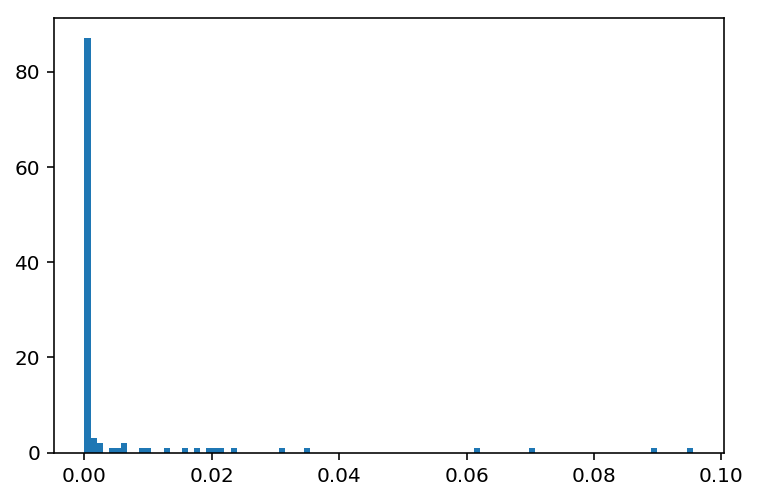

In [185]:
fig, ax = plt.subplots()

f = line_ratings["f"]
p = line_ratings["P>1"]
_=ax.hist(p[p>0], bins=100)

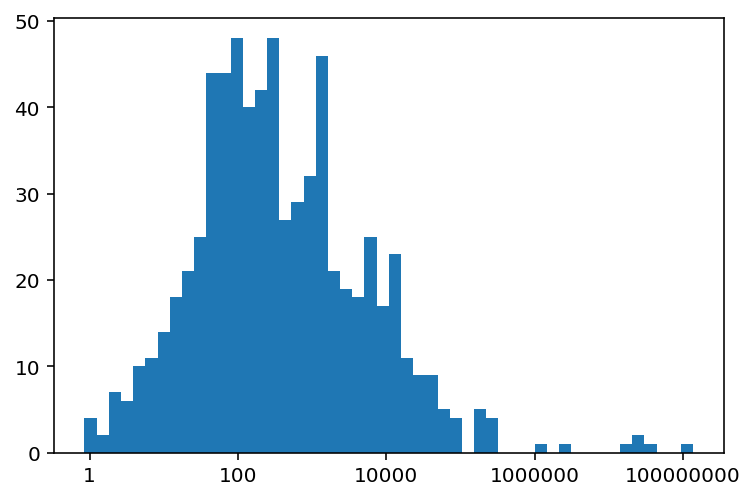

In [186]:
fig, ax = plt.subplots()

rate = line_ratings["rate"]
#_=ax.hist(rate[rate<2000], bins=50)
_=ax.hist(np.log(rate)/np.log(10), bins=50)

import matplotlib.ticker

ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, _: str(int(10**x))))

Text(0, 0.5, 'rate')

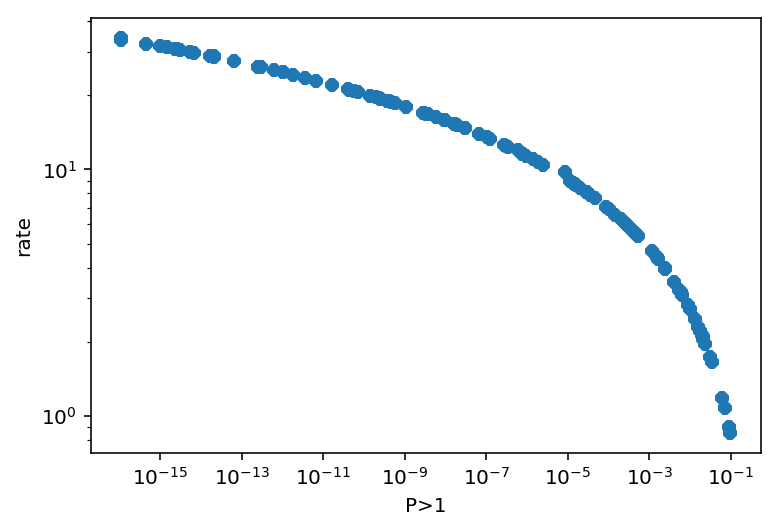

In [187]:
fig, ax = plt.subplots()


ax.set_xscale("log")
ax.set_yscale("log")
ax.plot(p[p>0], rate[p>0], "8")
ax.set_xlabel("P>1")
ax.set_ylabel("rate")



Text(0, 0.5, 'P>1')

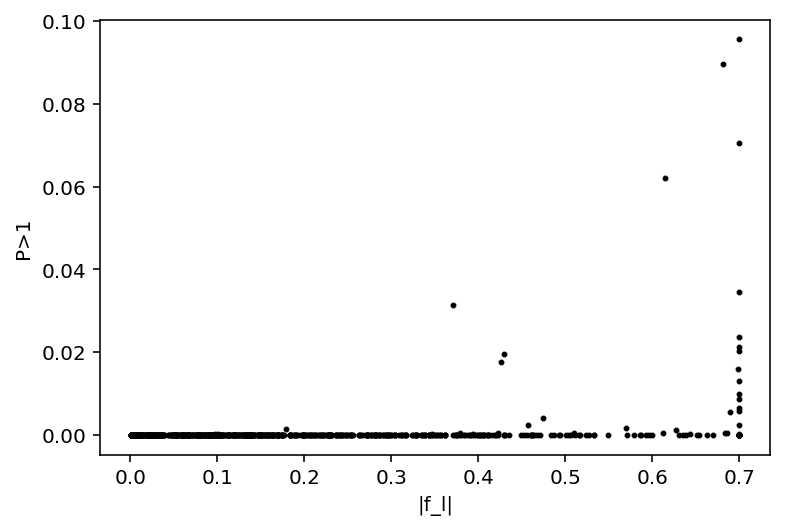

In [188]:
fig, ax = plt.subplots()



#ax.set_xscale("log")
#ax.set_yscale("log")
ax.plot(np.abs(f), p, "8", markersize=2, c="0")
ax.set_xlabel("|f_l|")
ax.set_ylabel("P>1")



Text(0, 0.5, 'P>1')

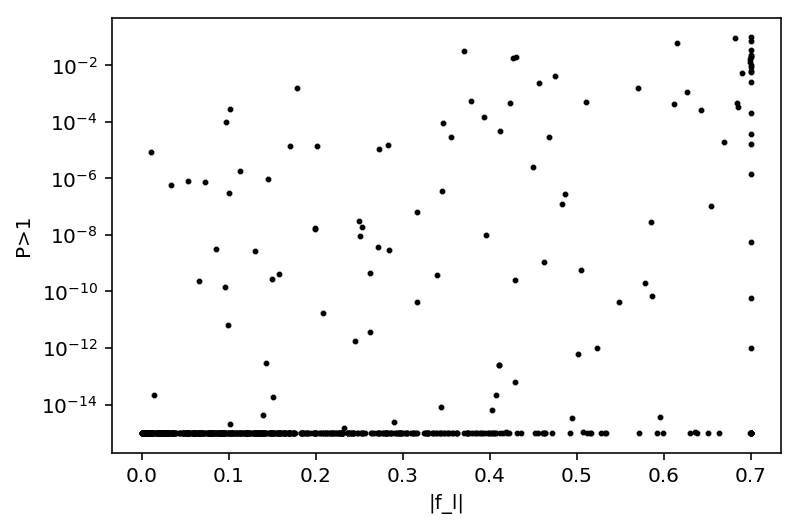

In [189]:
fig, ax = plt.subplots()



#ax.set_xscale("log")
ax.set_yscale("log")
ax.plot(np.abs(f), (p+1e-15), "8", markersize=2, c="0")
ax.set_xlabel("|f_l|")
ax.set_ylabel("P>1")



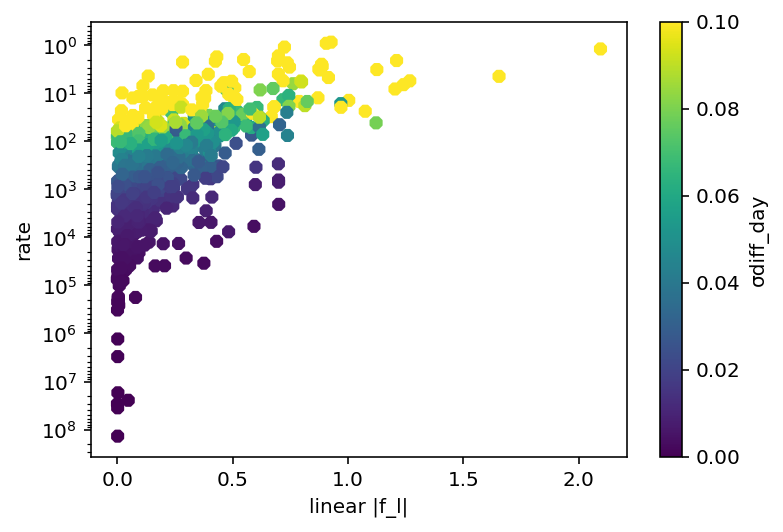

In [190]:
fig, ax = plt.subplots()



#ax.set_xscale("log")
ax.set_yscale("log")
ax.invert_yaxis()
scat = ax.scatter(np.abs(fav_sgn.line_saturation_linear.iloc[11,:]), rate, marker="8", c=line_ratings.σ)
ax.set_xlabel("linear |f_l|")
ax.set_ylabel("rate")
#ax.set_ylim(0,2000)

scat.set_clim(0,.1)

cbar = fig.colorbar(scat,ax=ax)
cbar.set_label("σdiff_day")


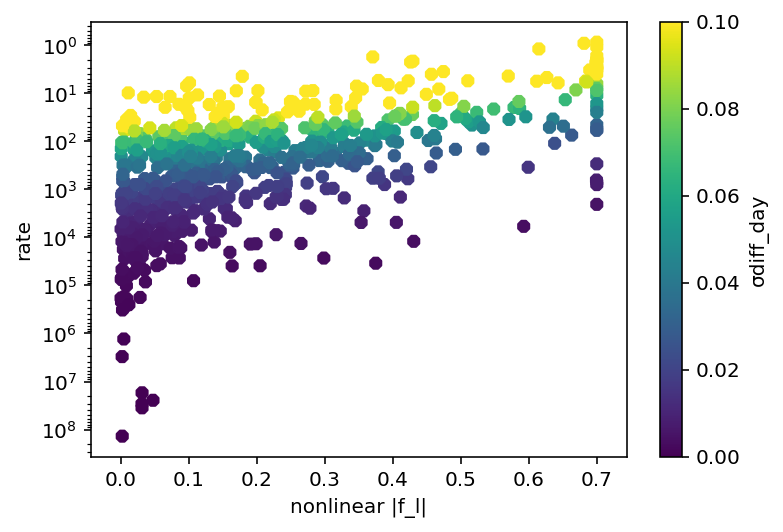

In [191]:
fig, ax = plt.subplots()



#ax.set_xscale("log")
ax.set_yscale("log")
ax.invert_yaxis()
scat=ax.scatter(np.abs(f), rate, marker="8", c=line_ratings.σ)
ax.set_xlabel("nonlinear |f_l|")
ax.set_ylabel("rate")
#ax.set_ylim(0,2000)

scat.set_clim(0,.1)

cbar = fig.colorbar(scat,ax=ax)
cbar.set_label("σdiff_day")


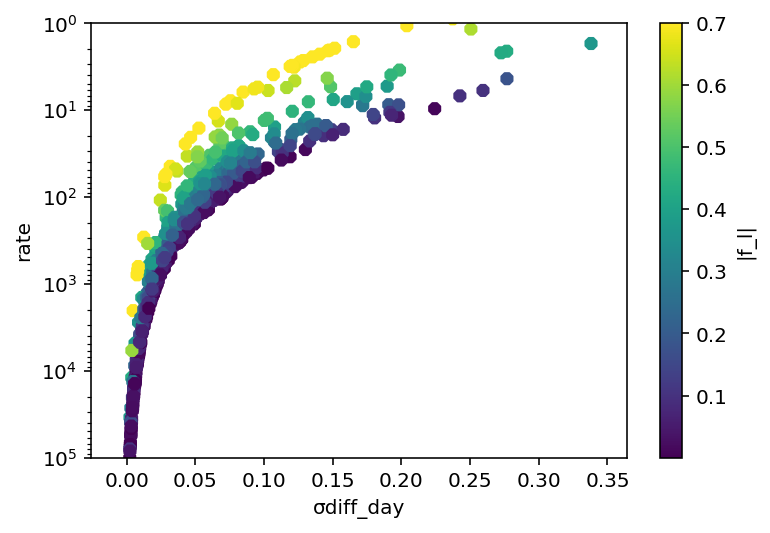

In [192]:
fig, ax = plt.subplots()



#ax.set_xscale("log")
ax.set_yscale("log")
scat=ax.scatter(line_ratings.σ, rate, marker="8", c=np.abs(f))
ax.set_xlabel("σdiff_day")
ax.set_ylabel("rate")
ax.set_ylim(1,1e5)
ax.invert_yaxis()

cbar = fig.colorbar(scat,ax=ax)
cbar.set_label("|f_l|")

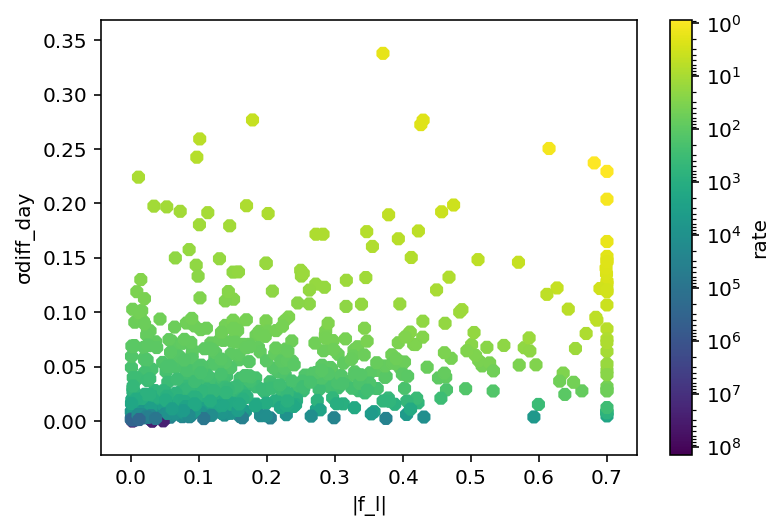

In [193]:
import matplotlib.colors

fig, ax = plt.subplots()



#ax.set_xscale("log")
#ax.set_yscale("log")
scat=ax.scatter(np.abs(f), line_ratings.σ, marker="8", c=rate, norm=matplotlib.colors.LogNorm(), cmap="viridis_r")
ax.set_xlabel("|f_l|")
ax.set_ylabel("σdiff_day")
#ax.set_ylim(0,2000)

#ax.set_cscale("log")

cbar = fig.colorbar(scat,ax=ax)
cbar.set_label("rate")
cbar.ax.invert_yaxis()

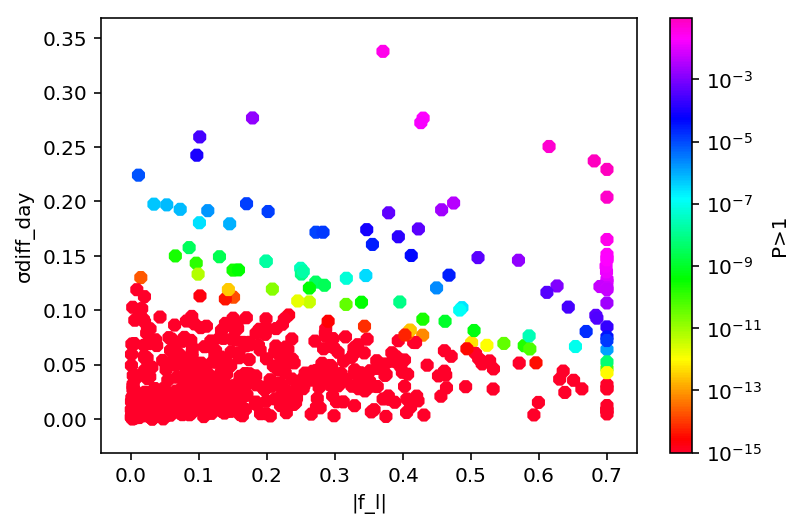

In [194]:
import matplotlib.colors

fig, ax = plt.subplots()



#ax.set_xscale("log")
#ax.set_yscale("log")
scat=ax.scatter(np.abs(f), line_ratings.σ, marker="8", c=(p+1e-15), norm=matplotlib.colors.LogNorm(), cmap="gist_rainbow")
ax.set_xlabel("|f_l|")
ax.set_ylabel("σdiff_day")
#ax.set_ylim(0,2000)

#ax.set_cscale("log")

cbar = fig.colorbar(scat,ax=ax)
cbar.set_label("P>1")

c:\dev\grid-analysis\venvwin\lib\site-packages\scipy\stats\_distn_infrastructure.py:1735: RuntimeWarning:

divide by zero encountered in true_divide

c:\dev\grid-analysis\venvwin\lib\site-packages\matplotlib\colors.py:1028: RuntimeWarning:

invalid value encountered in less_equal



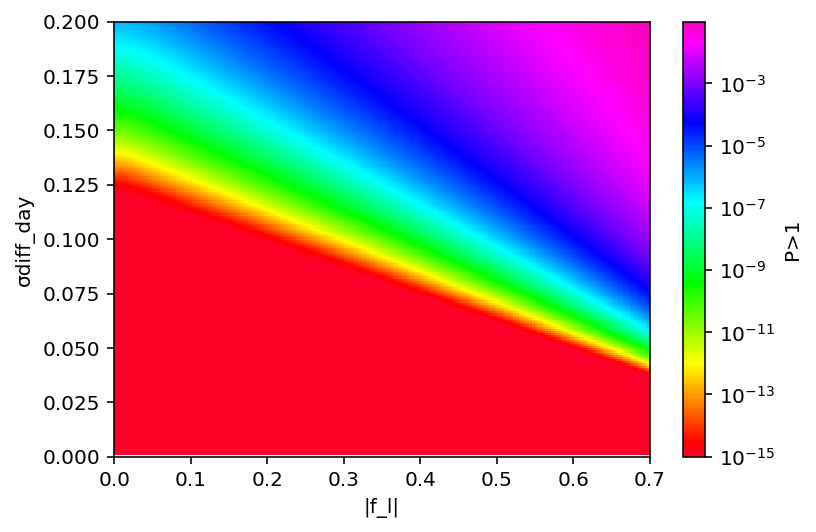

In [195]:
import matplotlib.colors

fig, ax = plt.subplots()


x = np.linspace(0,.7,num=200)
y = np.linspace(0,.2,num=200)

xx, yy = np.meshgrid(x,y)

extent = [x[0],x[-1],y[-1],y[0]]
ax.imshow(true_prob(xx,yy)+1e-15, norm=matplotlib.colors.LogNorm(), cmap="gist_rainbow", extent=extent, aspect="auto")
ax.set_xlabel("|f_l|")
ax.set_ylabel("σdiff_day")
ax.invert_yaxis()
#ax.set_ylim(0,2000)

#ax.set_cscale("log")

cbar = fig.colorbar(scat,ax=ax)
cbar.set_label("P>1")

In [196]:
true_prob(.7,.15)

0.02275013194817921

In [202]:
Cd = np.array(SciGRID_network.edge_vertex_incidence_matrix(fav_sgn.new_nodes, fav_sgn.new_lines).todense())
Cd

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [203]:
Ce = np.array(SciGRID_network.edge_vertex_incidence_matrix(fav_sgn.new_nodes, fav_sgn.new_lines).todense())
Ce

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

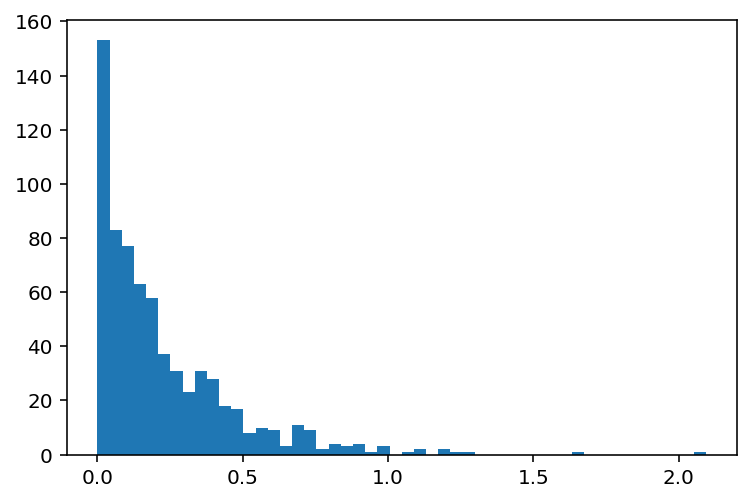

In [206]:
fig, ax = plt.subplots()

_=ax.hist(np.abs(fav_sgn.line_saturation_linear.values[11,:]), bins=50)

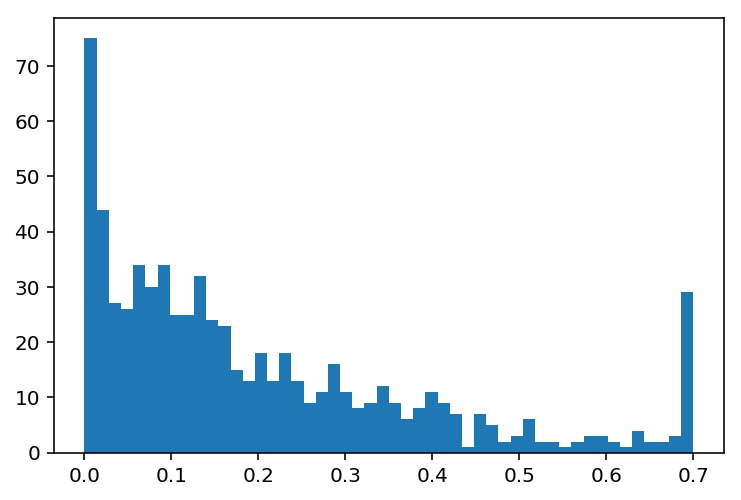

In [207]:
fig, ax = plt.subplots()

#sgn.line_saturation_nonlinear = sgn.line_flow_nonlinear / sgn.line_threshold

_=ax.hist(np.abs(fav_sgn.line_saturation_nonlinear.values[11,:]), bins=50)

# Bus covariance matrix

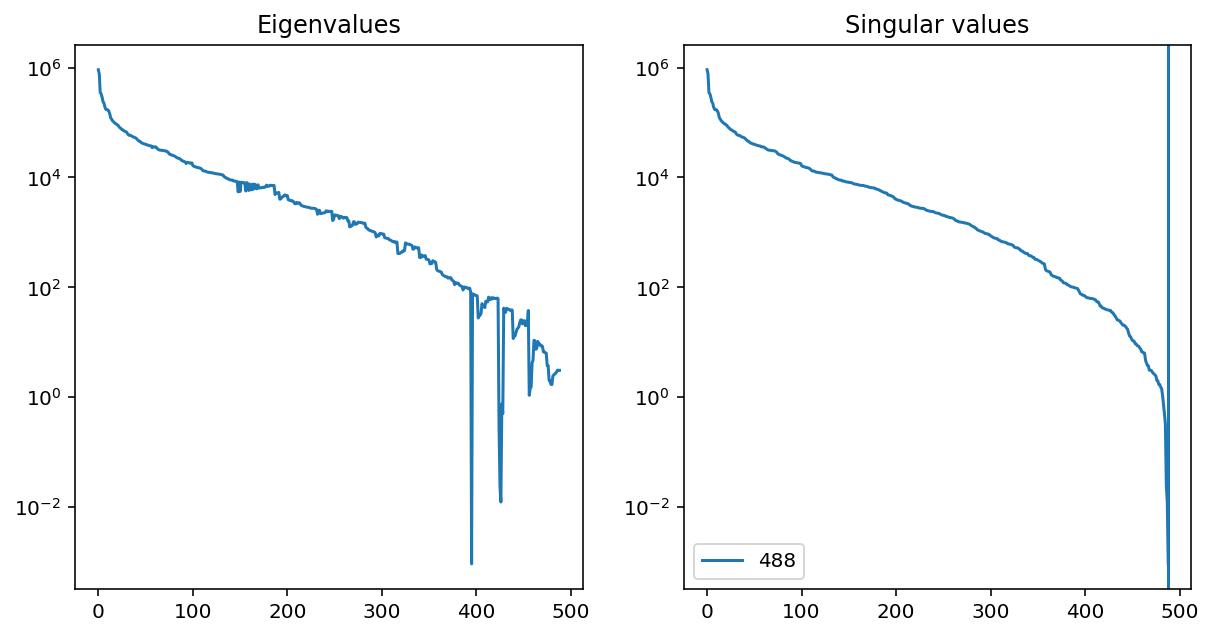

In [208]:
c = bus_diff_cov_day.copy()
c += np.diag(np.diag(c)) * 32

eig=np.linalg.eig(c)[0]
svd=np.linalg.svd(c)[1]
#z=np.linalg.svd(sgn.F)

printm("# Bus covariance matrix")

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(eig)
ax[0].set_yscale("log")
ax[0].set_title("Eigenvalues")
ax[1].plot(svd)
ax[1].set_yscale("log")
ax[1].set_title("Singular values")

ax[1].axvline(np.argmin(svd), label=str(np.argmin(svd)))
ax[1].legend()

# Line covariance matrix

c:\dev\grid-analysis\venvwin\lib\site-packages\numpy\core\numeric.py:501: ComplexWarning:

Casting complex values to real discards the imaginary part



Text(0.5, 1.0, 'Singular values')

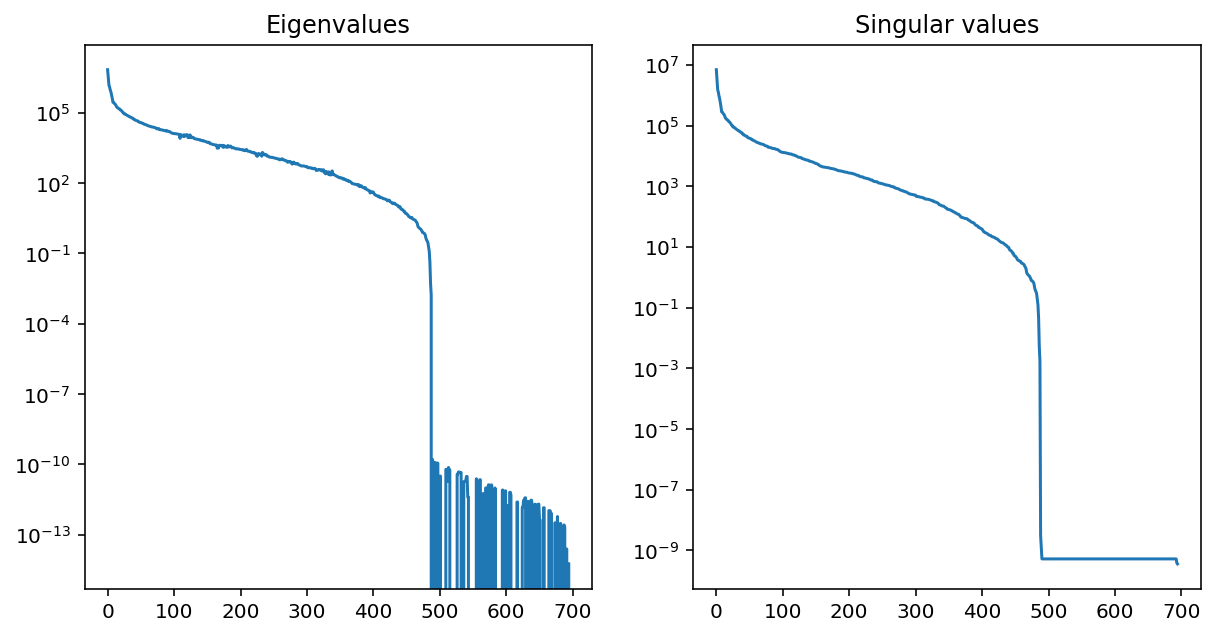

In [209]:
eig=np.linalg.eig(fav_sgn.F @ c @ fav_sgn.F.T)[0]
svd=np.linalg.svd(fav_sgn.F @ c @ fav_sgn.F.T)[1]
#z=np.linalg.svd(sgn.F)

printm("# Line covariance matrix")

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(eig)
ax[0].set_yscale("log")
ax[0].set_title("Eigenvalues")
ax[1].plot(svd)
ax[1].set_yscale("log")
ax[1].set_title("Singular values")


# LPF matrix

Text(0.5, 1.0, 'Singular values')

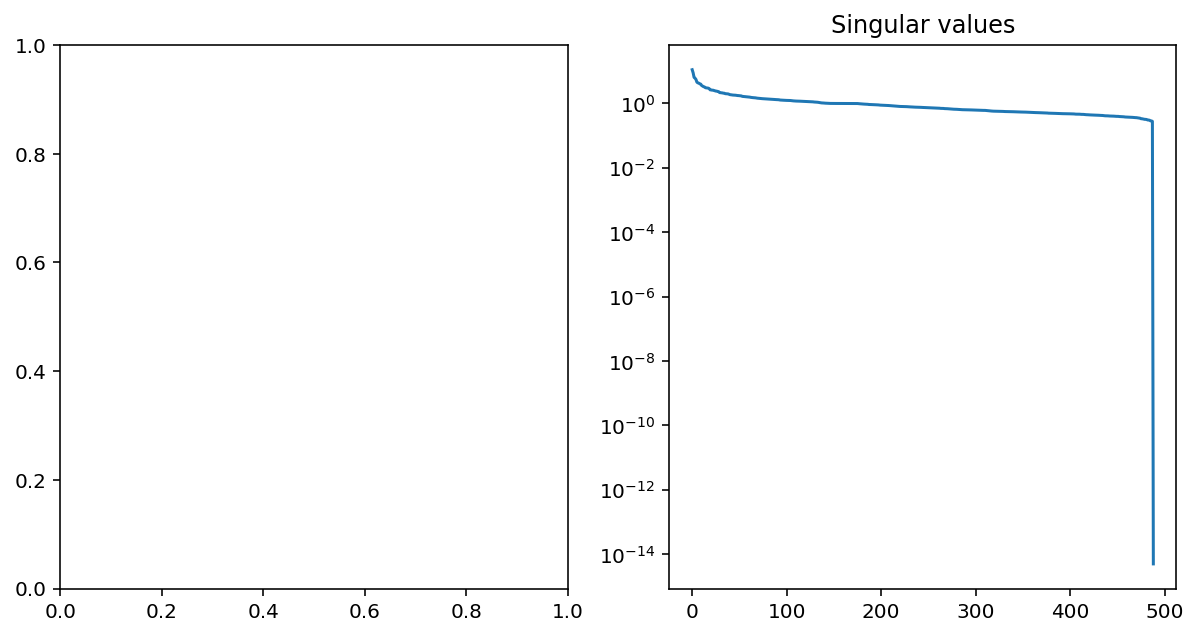

In [210]:
svd=np.linalg.svd(fav_sgn.F)[1]
#z=np.linalg.svd(sgn.F)

printm("# LPF matrix")

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[1].plot(svd)
ax[1].set_yscale("log")
ax[1].set_title("Singular values")


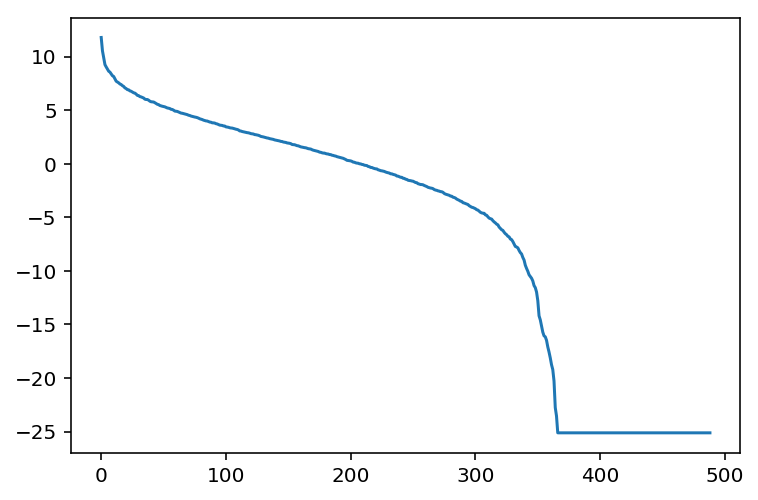

In [211]:
z=np.linalg.svd(bus_diff_cov_day)

#z=np.linalg.svd(sgn.F)
plt.plot(np.log(np.abs(z[1])))

In [212]:
sum(sgn.network.generators.source == "Wind Onshore")

488

In [213]:
s=sgn.solar_generation.sum(axis=1)
#pd.DataFrame({"generation":s, "cov:":np.diagonal(bus_diff_cov_day)})

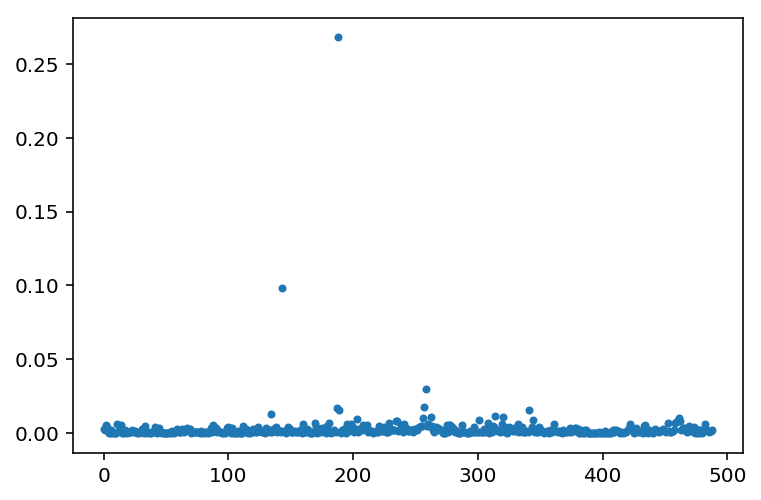

In [214]:
fig, ax = plt.subplots()

ax.plot(np.diagonal(bus_diff_cov_day) / s, ".")

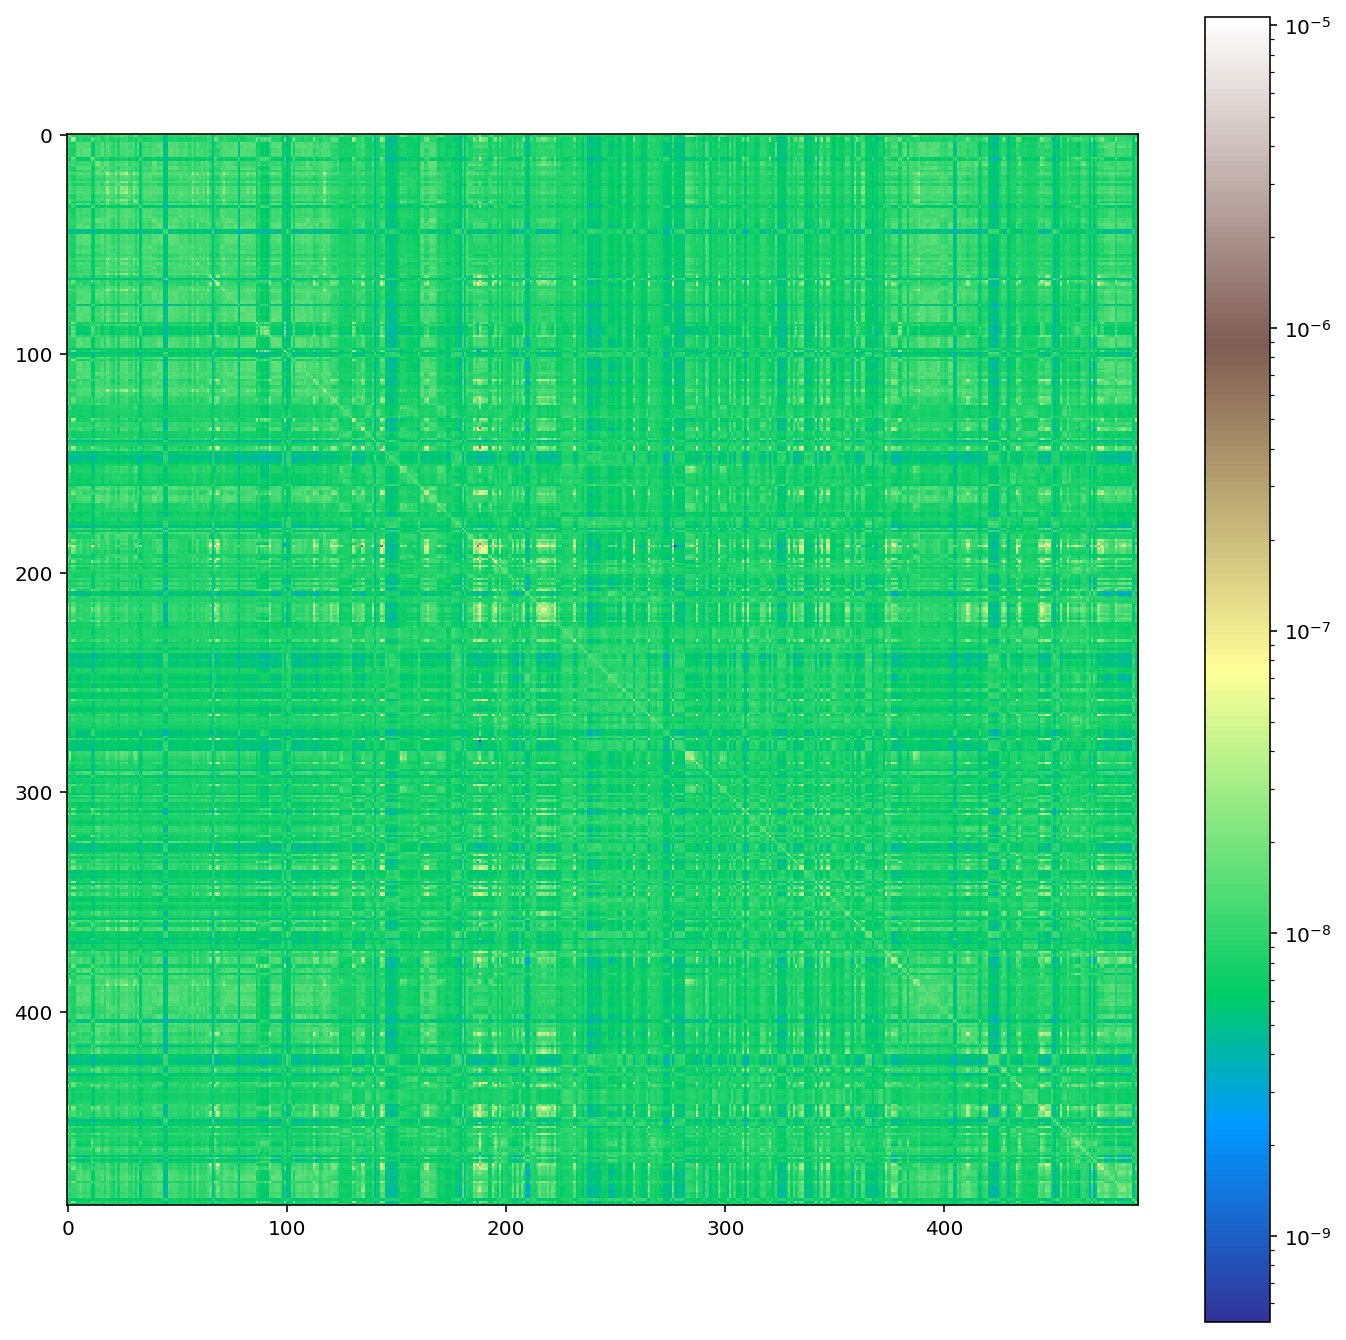

In [215]:
fig, ax = plt.subplots(figsize=(12,12))

sx, sy = np.meshgrid(s,s)

um=ax.imshow(bus_diff_cov_day /sx /sy, cmap="terrain", norm=matplotlib.colors.LogNorm())

fig.colorbar(um, ax=ax)

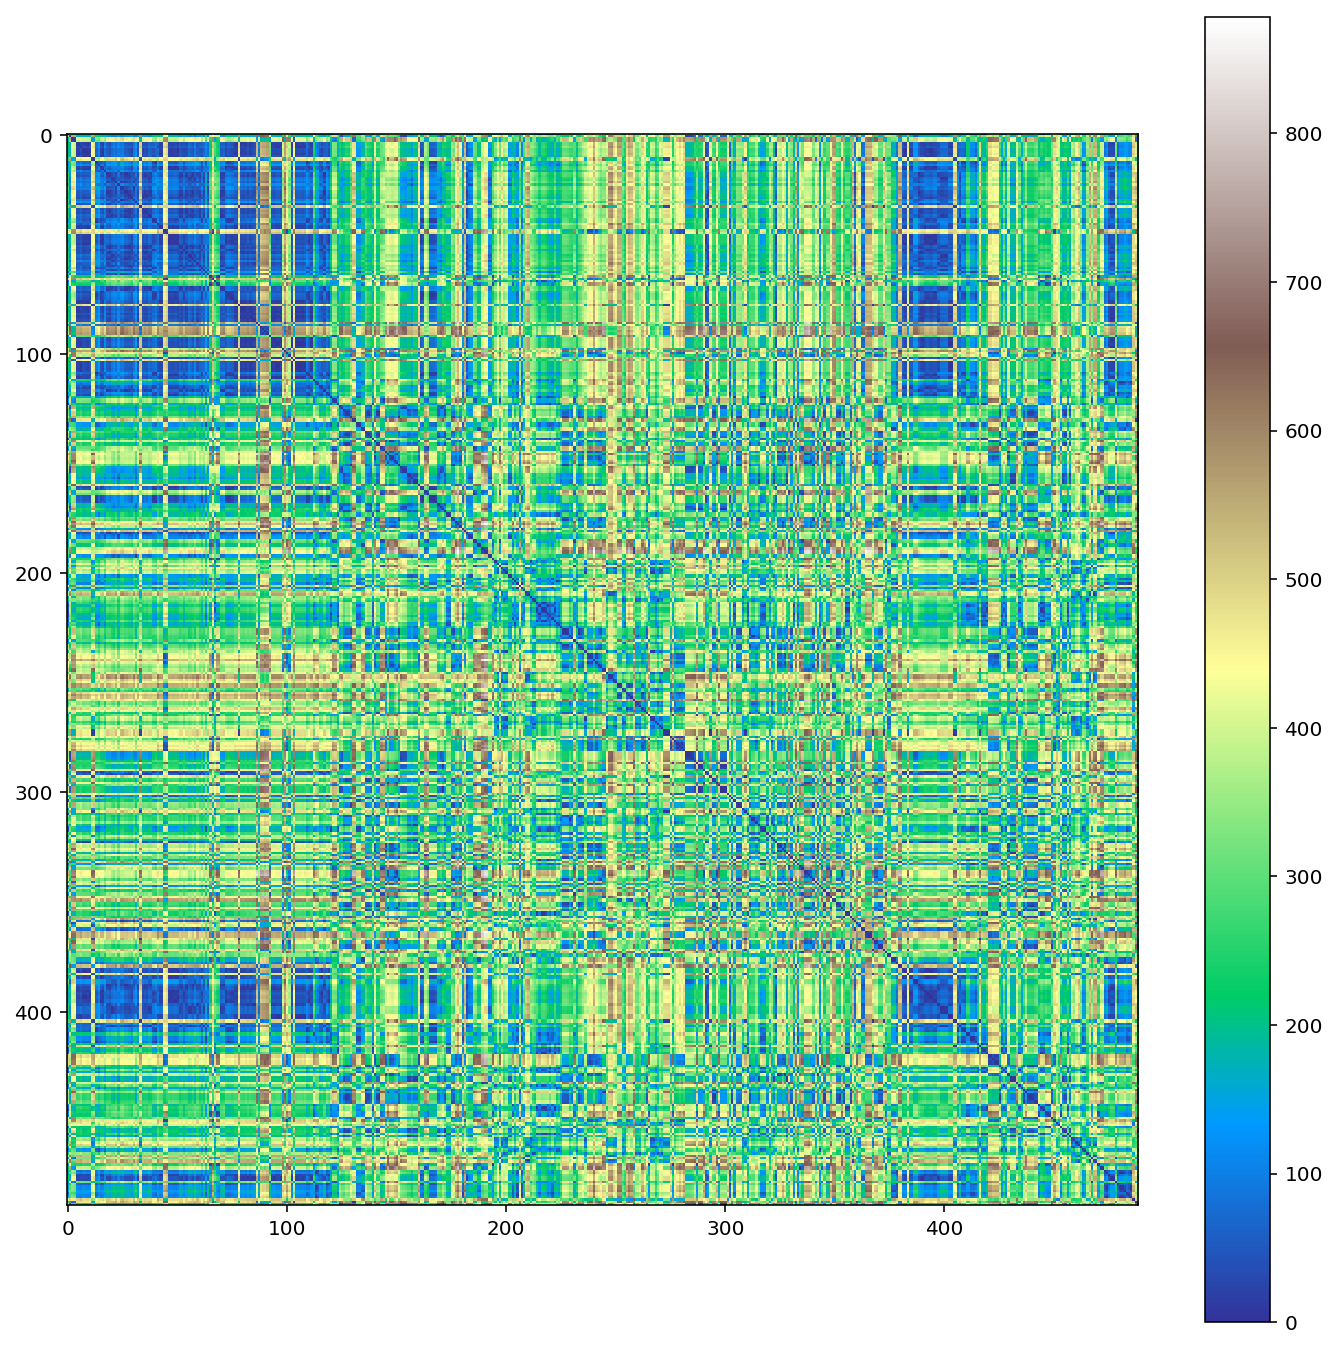

In [216]:
fig, ax = plt.subplots(figsize=(12,12))
distmat = sgn.get_dist_matrix()

um=ax.imshow(distmat, cmap="terrain")

fig.colorbar(um, ax=ax)

Text(0, 0.5, 'Covariance')

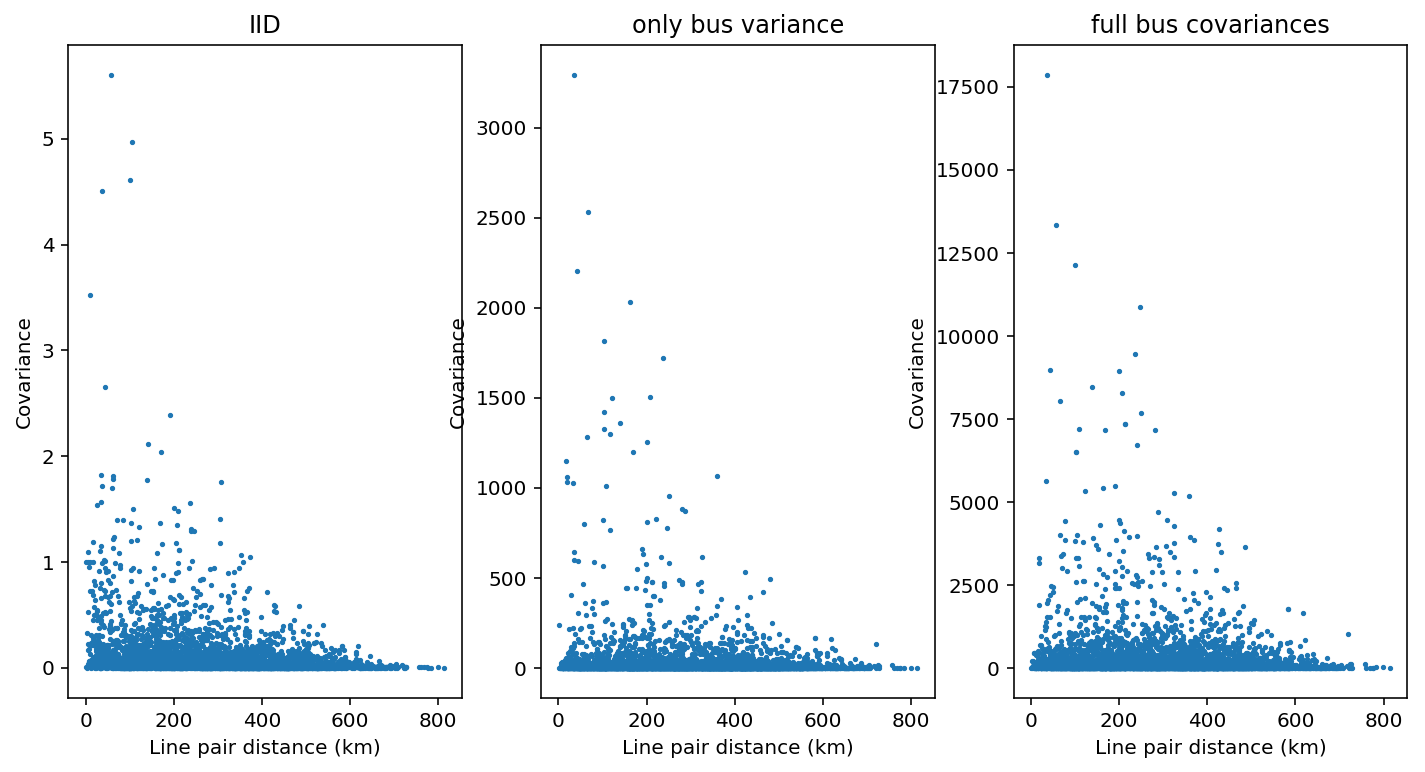

In [217]:
num_line_pairs = 5000

np.random.seed(1234)
pairs = zip(np.random.choice(range(fav_sgn.m), size=num_line_pairs), np.random.choice(range(fav_sgn.m), size=num_line_pairs))
pairs = list(pairs)

import itertools

def linedist(l, m):
    return sum(itertools.starmap(fav_sgn.dist, itertools.product(fav_sgn.new_lines[l], fav_sgn.new_lines[m]))) / 4


no_var = fav_sgn.F @ fav_sgn.F.T
no_cov = fav_sgn.F @ np.diag(np.diag(bus_diff_cov_night)) @ fav_sgn.F.T


pair_covs = np.array([line_diff_cov_night[p] for p in pairs])
pair_no_vars = np.array([no_var[p] for p in pairs])
pair_no_covs = np.array([no_cov[p] for p in pairs])
#pair_covs = np.array([line_diff_cov_day[p] for p in pairs])
pair_dists = np.array([linedist(*p) for p in pairs])
#pair_thresholds = np.array([fav_sgn.line_threshold[a]*fav_sgn.line_threshold[b] for a,b in pairs]) / 100000
#pair_admittances = np.array([fav_sgn.i_times_lineadmittance[a]*fav_sgn.i_times_lineadmittance[b] for a,b in pairs])
#pair_radii = np.array([linedist(a,200)*linedist(b,200) for a,b in pairs])


fig, ax = plt.subplots(1,3, figsize=(12,6))

uh=ax[0].scatter(pair_dists, np.abs(pair_no_vars), marker="8", s=3)
uh=ax[1].scatter(pair_dists, np.abs(pair_no_covs), marker="8", s=3)
uh=ax[2].scatter(pair_dists, np.abs(pair_covs), marker="8", s=3)

ax[0].set_title("IID")
ax[1].set_title("only bus variance")
ax[2].set_title("full bus covariances")

ax[0].set_xlabel("Line pair distance (km)")
ax[1].set_xlabel("Line pair distance (km)")
ax[2].set_xlabel("Line pair distance (km)")
ax[0].set_ylabel("Covariance")
ax[1].set_ylabel("Covariance")
ax[2].set_ylabel("Covariance")

#fig.colorbar(uh, ax=ax)

#ax[0].set_ylim(0, 50)
#ax[1].set_ylim(0, 1000)
#ax.set_yscale("log")

c:\dev\grid-analysis\venvwin\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning:

invalid value encountered in true_divide



Text(0.5, 1.0, 'double bus covariances')

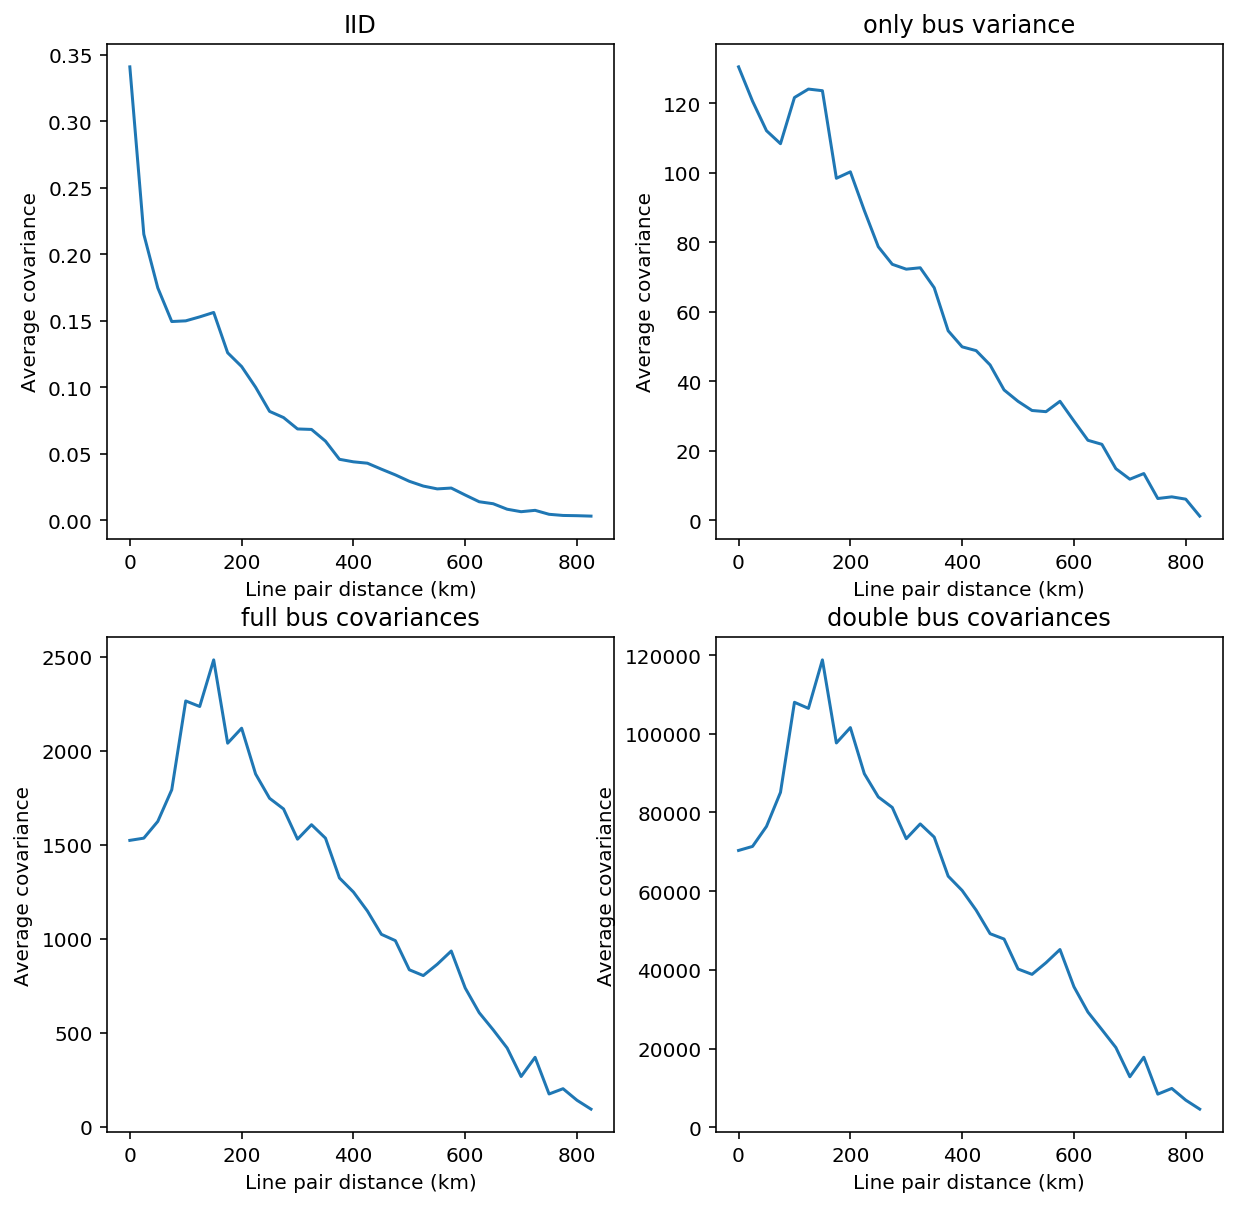

In [271]:
num_line_pairs = 100000

np.random.seed(1234)
pairs = zip(np.random.choice(range(fav_sgn.m), size=num_line_pairs), np.random.choice(range(fav_sgn.m), size=num_line_pairs))
pairs = list(pairs)

import itertools

#bus_dist = fav_sgn.get_dist_matrix()

# def linedist(l, m):
#     return sum(itertools.starmap(bus_dist.item, itertools.product(fav_sgn.new_lines[l], fav_sgn.new_lines[m]))) / 4

def linedist_centre(l, m):
    l_line = fav_sgn.new_lines[l]
    m_line = fav_sgn.new_lines[m]
    lxy0 = (fav_sgn.locations.x[l_line[0]], fav_sgn.locations.y[l_line[0]])
    lxy1 = (fav_sgn.locations.x[l_line[1]], fav_sgn.locations.y[l_line[1]])
    mxy0 = (fav_sgn.locations.x[m_line[0]], fav_sgn.locations.y[m_line[0]])
    mxy1 = (fav_sgn.locations.x[m_line[1]], fav_sgn.locations.y[m_line[1]])
    lxy = ((lxy0[0] + lxy1[0]) * .5, (lxy0[1] + lxy1[1]) * .5)
    mxy = ((mxy0[0] + mxy1[0]) * .5, (mxy0[1] + mxy1[1]) * .5)
    return np.sqrt(np.square(fav_sgn.lon2km(lxy[0] - mxy[0])) + np.square(fav_sgn.lat2km(lxy[1] - mxy[1])))

no_var = fav_sgn.F @ fav_sgn.F.T
no_cov = fav_sgn.F @ np.diag(np.diag(bus_diff_cov_day)) @ fav_sgn.F.T
full_cov = fav_sgn.F @ bus_diff_cov_day @ fav_sgn.F.T
more_cov = 50.0 * line_diff_cov_day - 49.0 * no_cov

pair_dists = np.array([linedist_centre(*p) for p in pairs])
#pair_thresholds = np.array([fav_sgn.line_threshold[a]*fav_sgn.line_threshold[b] for a,b in pairs]) / 100000
#pair_admittances = np.array([fav_sgn.i_times_lineadmittance[a]*fav_sgn.i_times_lineadmittance[b] for a,b in pairs])
#pair_radii = np.array([linedist(a,200)*linedist(b,200) for a,b in pairs])


bins = np.arange(0,900,25)

fig, ax = plt.subplots(2,2, figsize=(10,10))
ax = ax.flatten()

for i, line_covs in enumerate([no_var, no_cov, full_cov, more_cov]):
    pair_covs = np.array([line_covs[p] for p in pairs])
    nums, _ = np.histogram(pair_dists, bins=bins)
    sums, _ = np.histogram(pair_dists, weights=np.abs(pair_covs), bins=bins)
    ax[i].plot(bins[:-1], sums/nums)
    ax[i].set_xlabel("Line pair distance (km)")
    ax[i].set_ylabel("Average covariance")



#uh=ax[0].scatter(pair_dists, np.abs(pair_no_vars), marker="8", s=3)
#uh=ax[1].scatter(pair_dists, np.abs(pair_no_covs), marker="8", s=3)
#uh=ax[2].scatter(pair_dists, np.abs(pair_covs), marker="8", s=3)

ax[0].set_title("IID")
ax[1].set_title("only bus variance")
ax[2].set_title("full bus covariances")
ax[3].set_title("double bus covariances")

#fig.colorbar(uh, ax=ax)

#ax[0].set_ylim(0, 50)
#ax[1].set_ylim(0, 1000)
#ax.set_yscale("log")

c:\dev\grid-analysis\venvwin\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning:

invalid value encountered in true_divide



# $10^5$ random line pairs

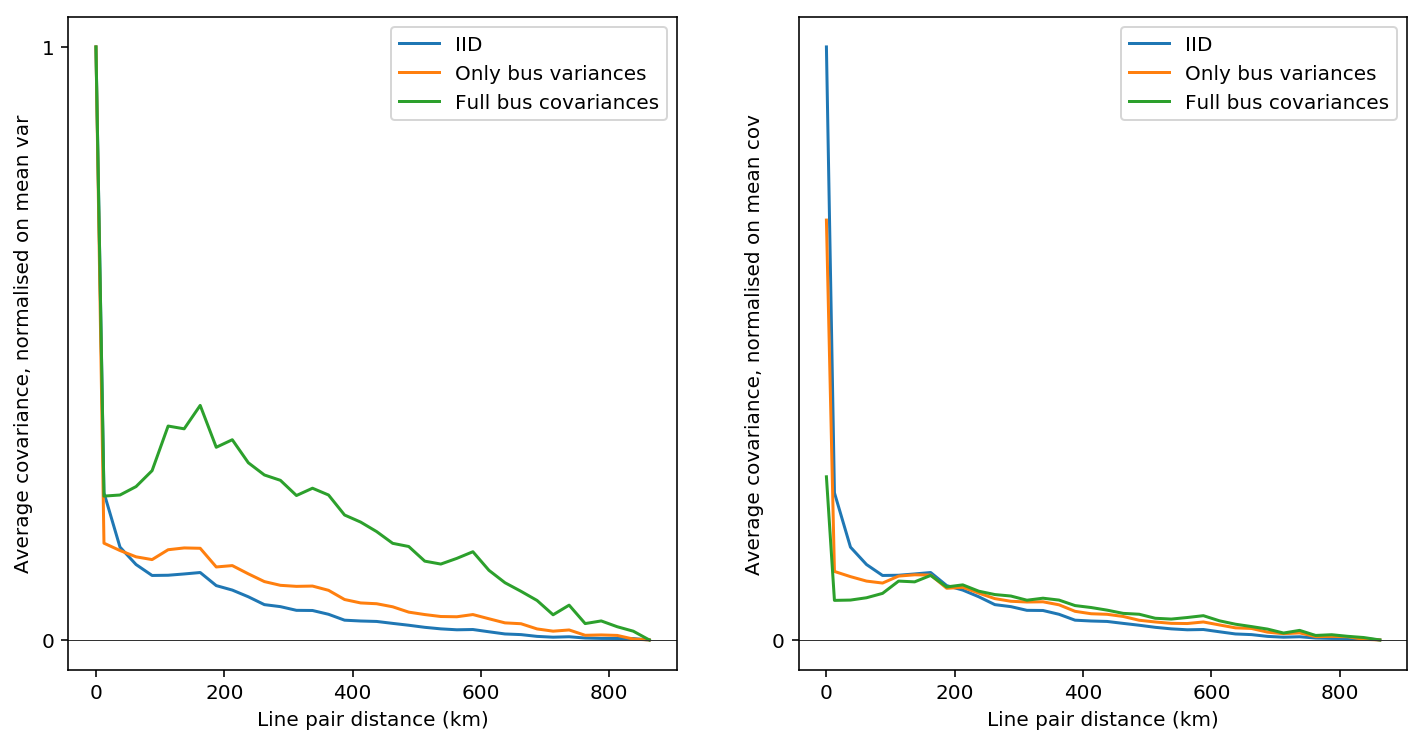

In [272]:
bins = np.arange(0, 900, 25)

fig, ax = plt.subplots(1,2,figsize=(12,6))

for i, (line_covs, name) in enumerate([(no_var, "IID"), (no_cov, "Only bus variances"), (full_cov, "Full bus covariances")]):
    pair_covs = np.array([line_covs[p] for p in pairs])
    nums, _ = np.histogram(pair_dists, bins=bins)
    sums, _ = np.histogram(pair_dists, weights=np.abs(pair_covs), bins=bins)
    
    avg_var = np.mean(np.diag(line_covs))
    
    x = (bins[1:]+bins[:-1])/2
    y = sums/nums
    y[np.isnan(y)] = 0
    ax[0].plot([0] + list(x), [1] + list(y / avg_var), label=name)
    ax[1].plot([0] + list(x), [avg_var / np.mean(y)] + list(y / np.mean(y)), label=name)
#     ax[2].plot(x, y / y[0], label=name)
#     ax[2].set_xlabel("Line pair distance (km)")
#     ax[2].set_ylabel("Average covariance, normalised")


ax[0].legend()
ax[1].legend()

#fig.colorbar(uh, ax=ax)

#ax[0].set_ylim(0, 50)
#ax[1].set_ylim(0, 1000)
#ax.set_yscale("log")
ax[0].set_xlabel("Line pair distance (km)")
ax[0].set_ylabel("Average covariance, normalised on mean var")
ax[1].set_xlabel("Line pair distance (km)")
ax[1].set_ylabel("Average covariance, normalised on mean cov")

ax[0].axhline(0,color="#333333",linewidth=.5)
ax[1].axhline(0,color="#333333",linewidth=.5)

ax[0].yaxis.set_ticks([0,1])
ax[1].yaxis.set_ticks([0])

printm("# $10^5$ random line pairs")

In [270]:
np.max(pair_dists)

638.6120685576959

c:\dev\grid-analysis\venvwin\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning:

invalid value encountered in true_divide



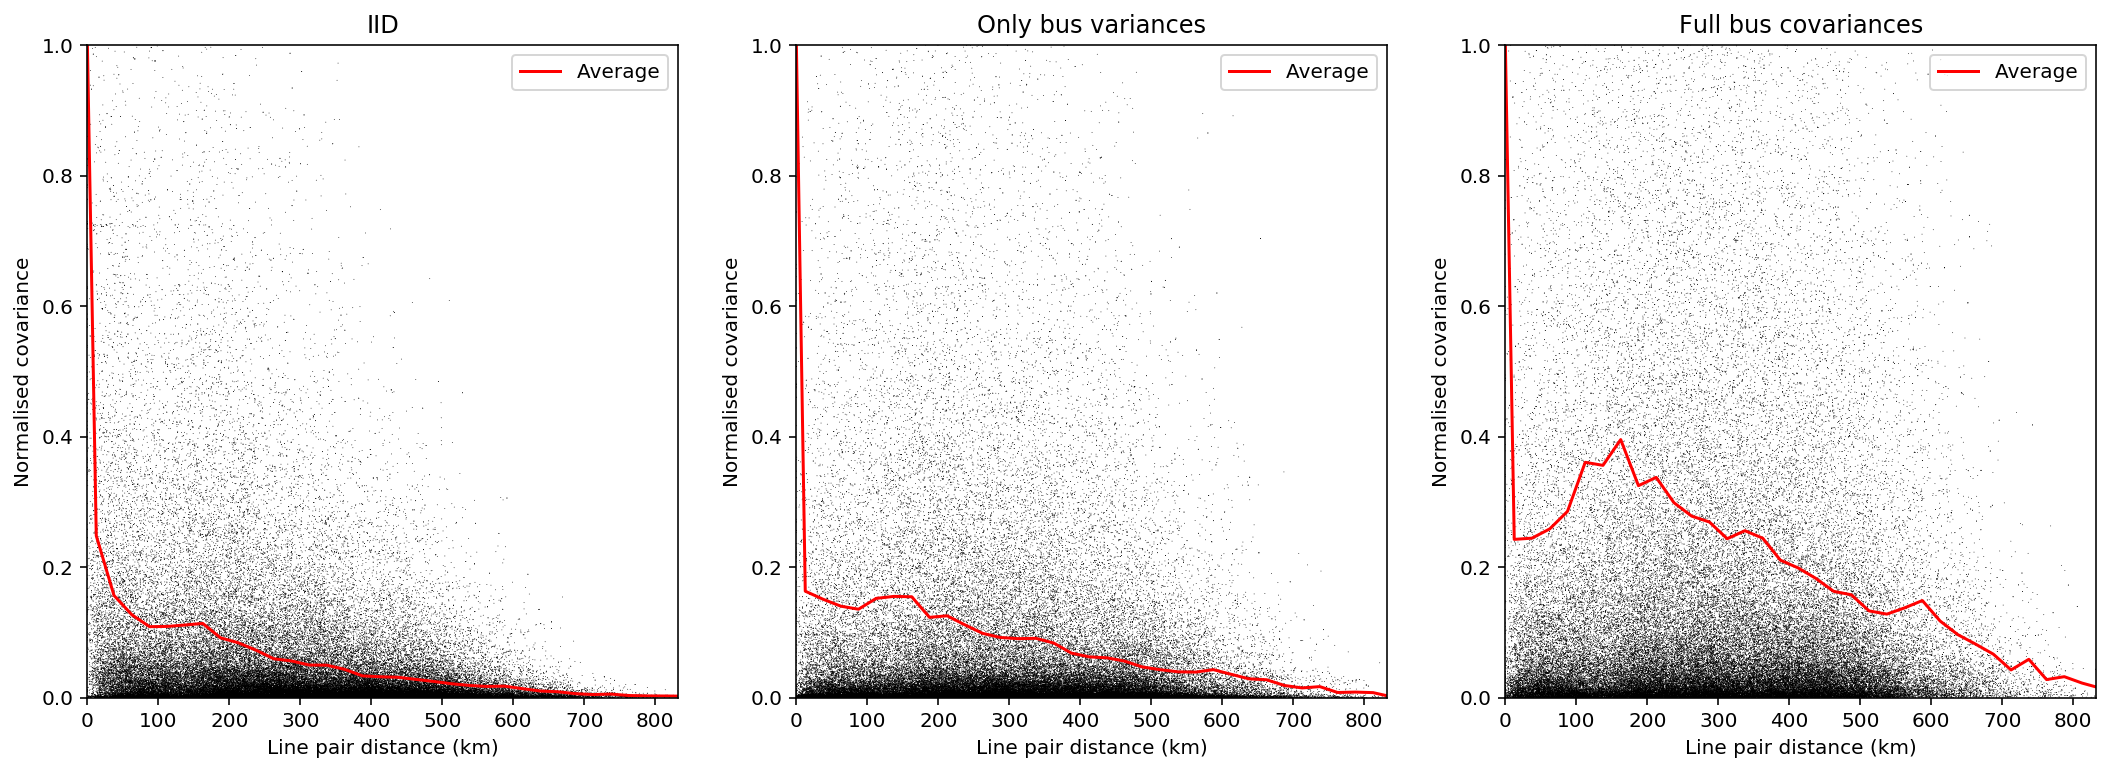

In [302]:
bins = np.arange(0, 900, 25)

fig, ax = plt.subplots(1,3,figsize=(18,6))

for i, (line_covs, name) in enumerate([(no_var, "IID"), (no_cov, "Only bus variances"), (full_cov, "Full bus covariances")]):
    pair_covs = np.array([line_covs[p] for p in pairs])
    nums, _ = np.histogram(pair_dists, bins=bins)
    sums, _ = np.histogram(pair_dists, weights=np.abs(pair_covs), bins=bins)
    
    avg_var = np.mean(np.diag(line_covs))
    
    x = (bins[1:]+bins[:-1])/2
    y = sums/nums
    y[np.isnan(y)] = 0
    
    ax[i].scatter(pair_dists, np.abs(pair_covs) / avg_var, marker="8", s=.2, edgecolors="none", c="0", rasterized=True)
    ax[i].plot([0] + list(x), [1] + list(y / avg_var), c="red", label="Average")
#     ax[i].plot(bins, np.exp(-np.sqrt(bins/40)))
    ax[i].set_title(name)
    
    ax[i].set_xlabel("Line pair distance (km)")
    ax[i].set_ylabel("Normalised covariance")
    ax[i].axhline(0,color="#333333",linewidth=.5)
    ax[i].legend()
    ax[i].set_ylim(0,1)
    ax[i].set_xlim(0,np.max(pair_dists))

#printm("# $10^5$ random line pairs")
plt.savefig("covariance_linepairs_with_average.pdf" ,bbox_inches="tight", dpi=300)

# $10^5$ random line pairs

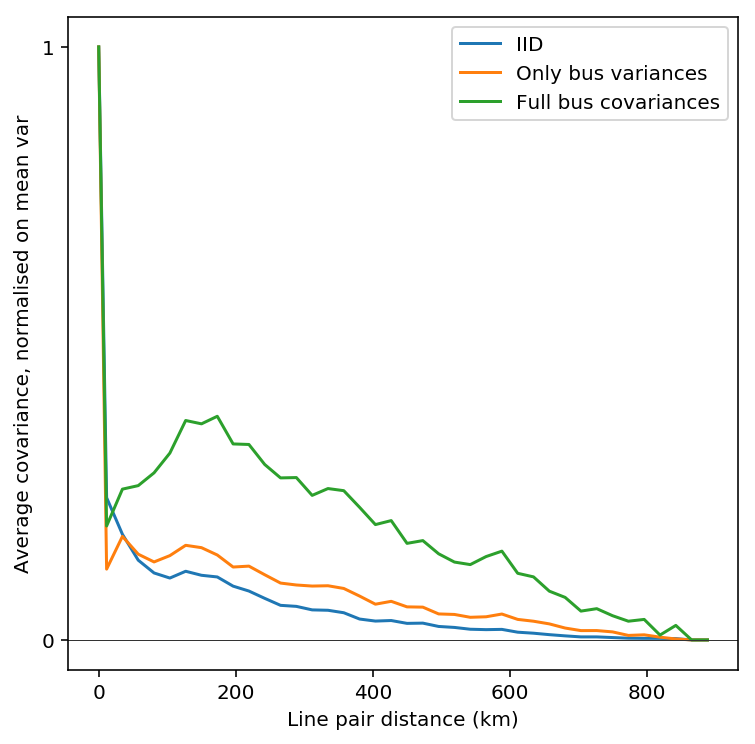

In [262]:
bins = np.linspace(0, 900, num=40)

fig, ax = plt.subplots(figsize=(6,6))
ax=[ax]

for i, (line_covs, name) in enumerate([(no_var, "IID"), (no_cov, "Only bus variances"), (full_cov, "Full bus covariances")]):
    pair_covs = np.array([line_covs[p] for p in pairs])
    
    nums = np.zeros(len(bins)-1)
    avgs = np.zeros(len(bins)-1)
    stds = np.zeros(len(bins)-1)
    
    abs_covs = np.abs(pair_covs)
    
    for i, (l, r) in enumerate(zip(bins[:-1], bins[1:])):
        are_inside = np.logical_and(l <= pair_dists, pair_dists < r)
        nums[i] = sum(are_inside)
        if nums[i] > 0:
            avgs[i] = np.mean(abs_covs[are_inside])
            stds[i] = np.std(abs_covs[are_inside])
    
    avg_var = np.mean(np.diag(line_covs))
    
    x = (bins[1:]+bins[:-1])/2
    y = avgs
    y[np.isnan(y)] = 0
    
#     ax[0].errorbar([0] + list(x), [1] + list(y / avg_var), yerr=([0] + list(stds / avg_var)), label=name)
    ax[0].plot([0] + list(x), [1] + list(y / avg_var), label=name)


ax[0].legend()

#fig.colorbar(uh, ax=ax)

#ax[0].set_ylim(0, 50)
#ax[1].set_ylim(0, 1000)
#ax.set_yscale("log")
ax[0].set_xlabel("Line pair distance (km)")
ax[0].set_ylabel("Average covariance, normalised on mean var")

ax[0].axhline(0,color="#333333",linewidth=.5)

ax[0].yaxis.set_ticks([0,1])

printm("# $10^5$ random line pairs")

plt.savefig("line_covariance_vs_line_distance.pdf", bbox_inches="tight")

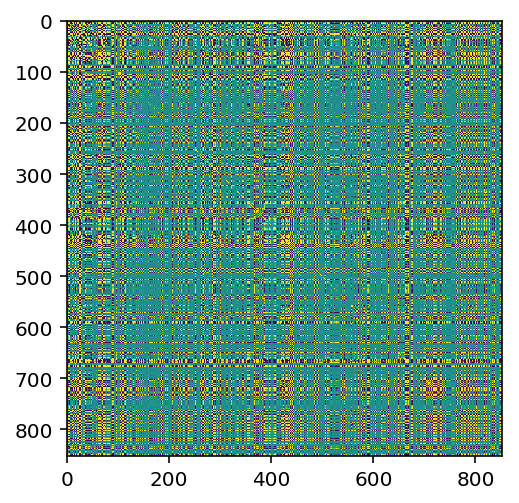

In [537]:
plt.imshow(no_cov, vmin=-10, vmax=10)

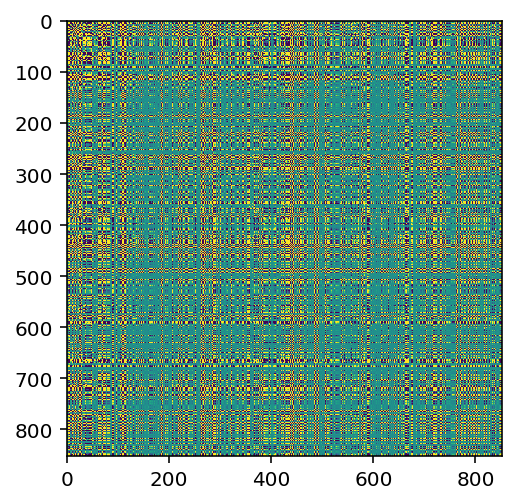

In [538]:
plt.imshow(line_diff_cov_night, vmin=-100, vmax=100)

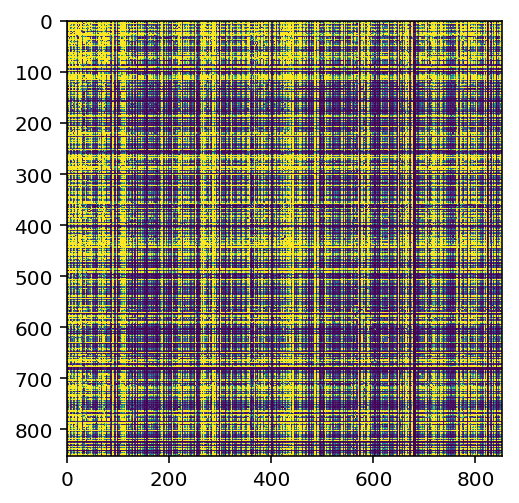

In [622]:
plt.imshow(np.abs(line_diff_cov_night),vmax=100)

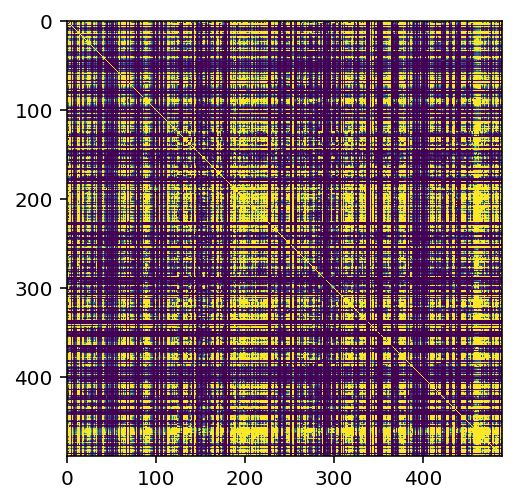

In [634]:
c = bus_res_cov_night

c += np.diag(np.diag(c))*32

plt.imshow(np.abs(c), vmax=1)#, vmin=-100, vmax=100)

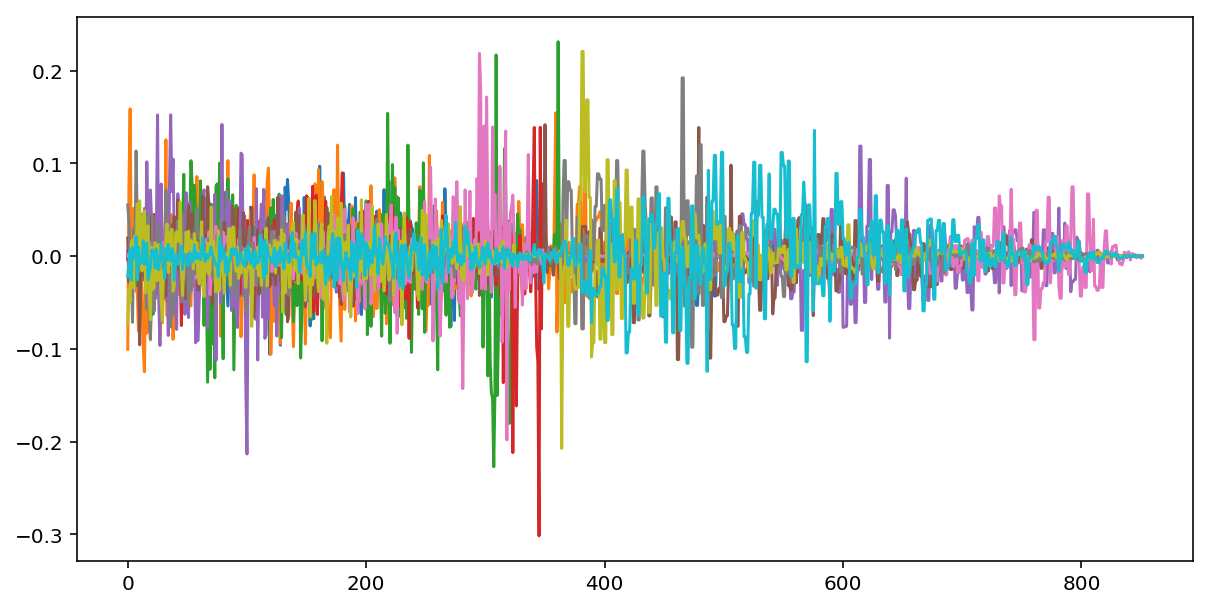

In [598]:
fig, ax = plt.subplots(figsize=(10,5))

z = np.linalg.eig(line_diff_cov_day)
for i in range(0,100,10):
    ax.plot(z[1][i,:])
#z[0][0,:]

(<matplotlib.collections.PathCollection at 0x22626ae13c8>,
 <matplotlib.collections.LineCollection at 0x22626ae17b8>)

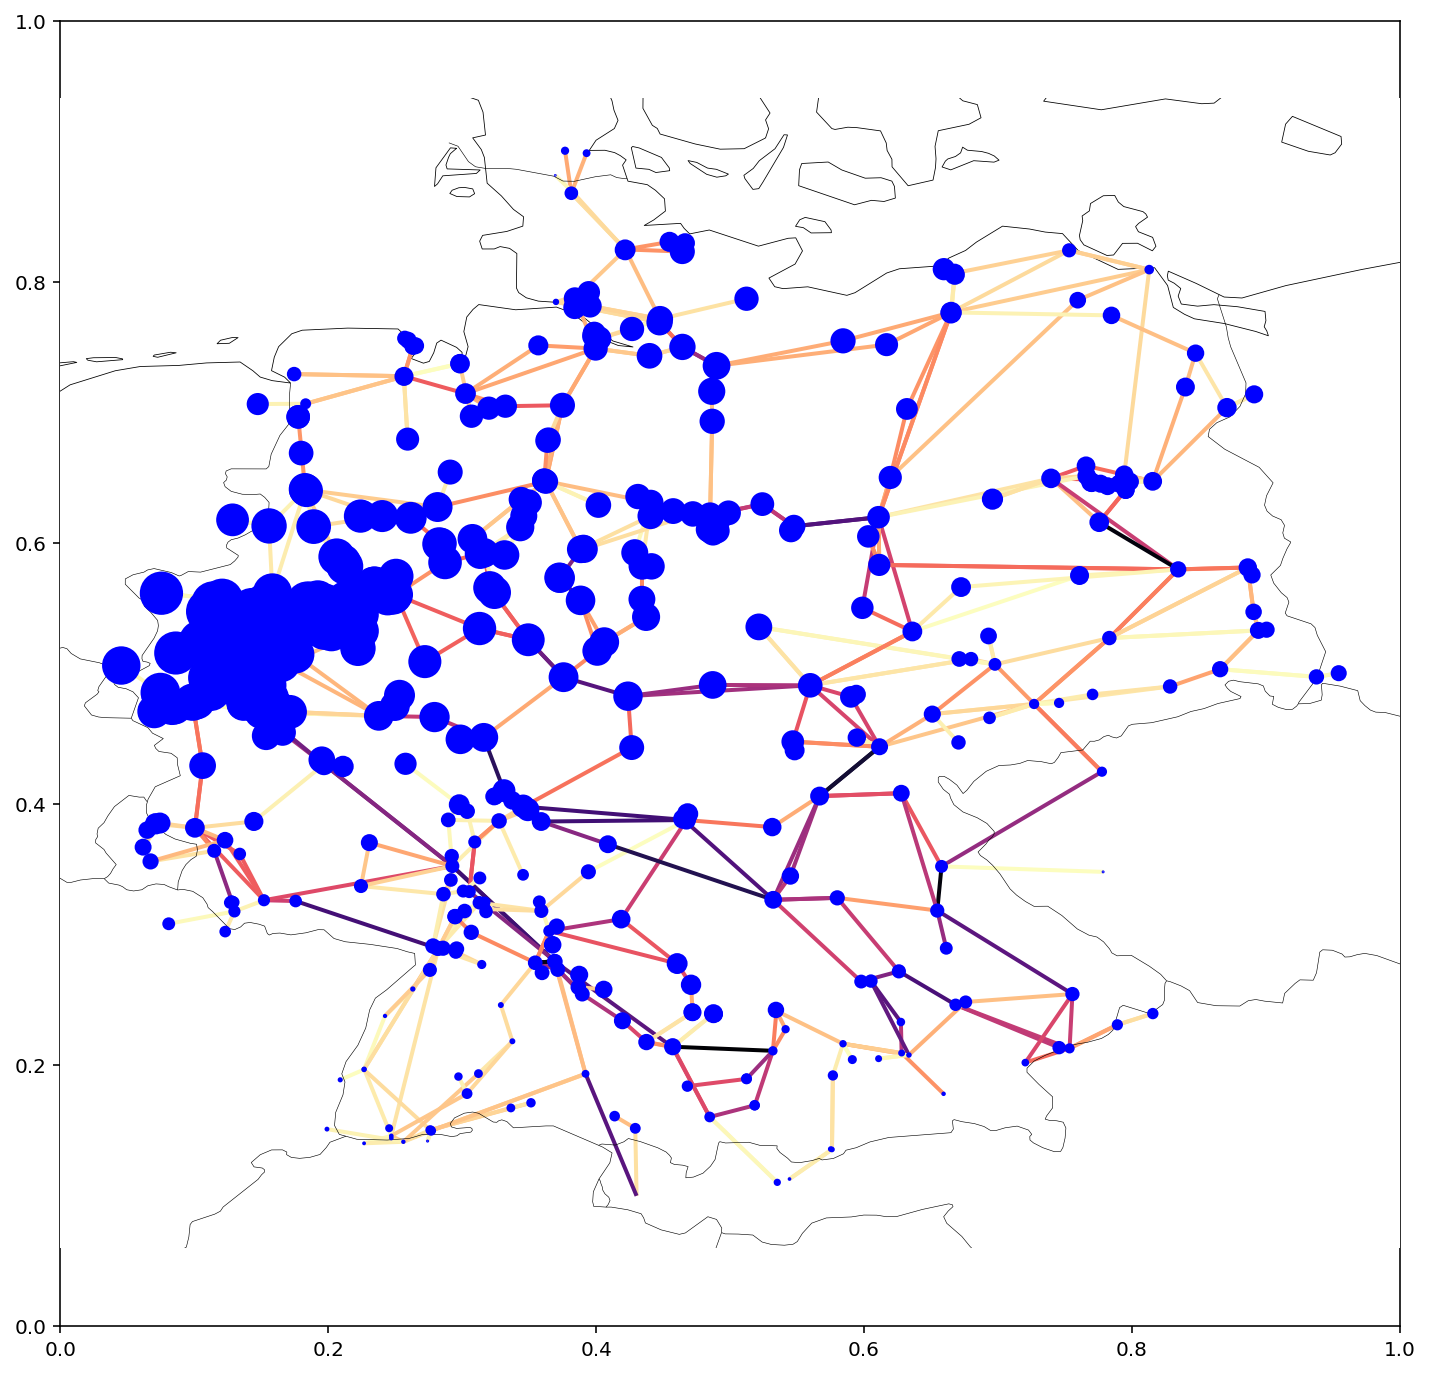

In [671]:
fig, ax = plt.subplots(figsize=(12,12))


bus_sizes = [0]*len(fav_sgn.network.buses)
bus_colors = ['g']*len(fav_sgn.network.buses)

for i, bus_name in enumerate(fav_sgn.network.buses.index):
    if bus_name in fav_sgn.new_nodes:
        powerinj = (wind_diff_cov_norm[390])[fav_sgn.node_index(bus_name)]
        bus_sizes[i] = np.abs(powerinj) * 100000
        bus_colors[i] = 'g' if powerinj > 0 else 'y'


fav_sgn.network.plot(basemap=True, bus_sizes=bus_sizes, line_colors=np.abs(line_diff_cov_day[555])/fav_sgn.line_threshold, line_cmap="magma_r")
#fav_sgn.network.plot(basemap=True, bus_sizes=0, line_colors=range(fav_sgn.m), line_cmap="magma_r")

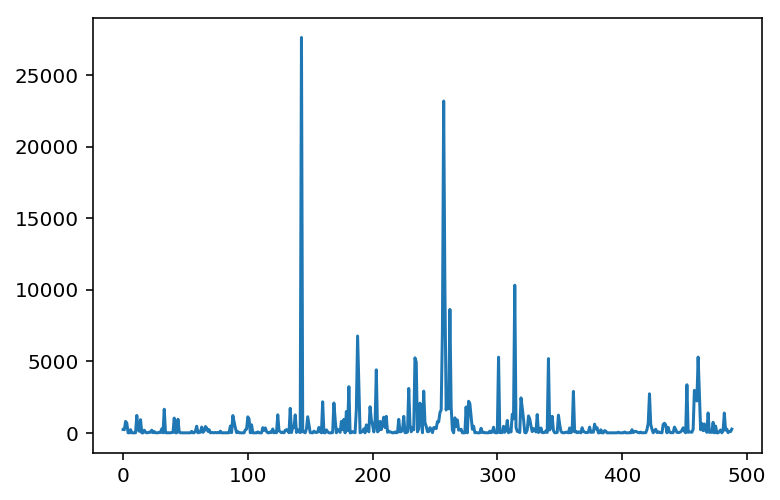

In [141]:
fig, ax = plt.subplots()
ax.plot(np.diag(bus_diff_cov_day))
#ax.set_yscale("log")

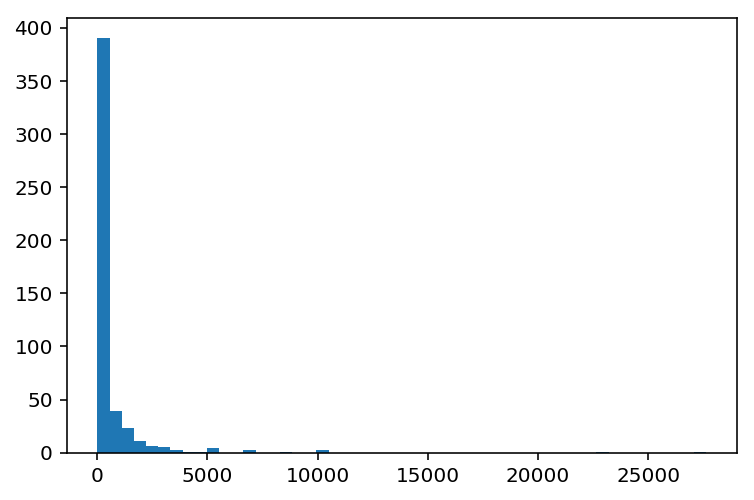

In [138]:
_=plt.hist(np.diag(bus_diff_cov_day), bins=50)

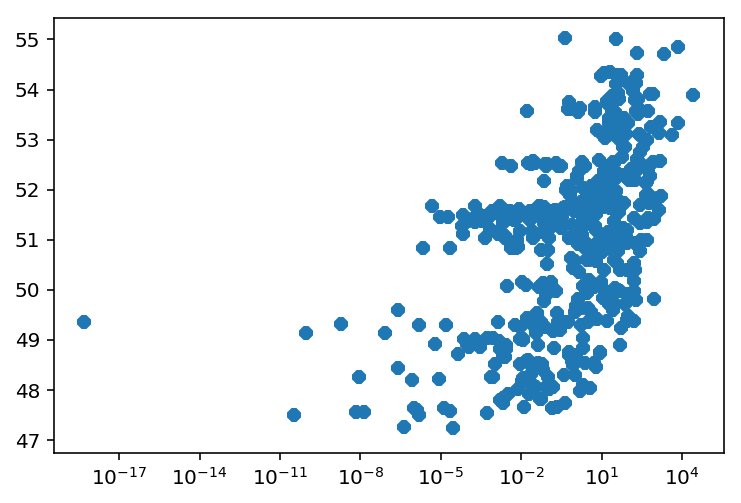

In [150]:
fig, ax = plt.subplots()

latitudes = fav_sgn.locations.y

ax.plot(np.diag(wind_diff_cov), latitudes, "8")
ax.set_xscale("log")